<a href="https://colab.research.google.com/github/franciscogazaniga/TCC_Aprendizado_Maquina_Previsao_Energia_Fotovoltaica/blob/main/AED.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Import

In [2]:
%%capture
!pip install kaleido
!pip install plotly>=4.0.0
!wget https://github.com/plotly/orca/releases/download/v1.2.1/orca-1.2.1-x86_64.AppImage -O /usr/local/bin/orca
!chmod +x /usr/local/bin/orca
!apt-get install xvfb libgtk2.0-0 libgconf-2-4

In [3]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt # .pyplot é uma interface para o matplotlib que permite a geração de gráficos ao estilo MATLAB
import seaborn as sns # api para plotar gráficos
import plotly.express as px # api para plotar gráficos interativos
import plotly.graph_objects as go # para criar histogramas sobrepostos
import os # para salvar gráficos gerados pelo plotly
import statsmodels.api as sm

from statsmodels.stats.outliers_influence import variance_inflation_factor # para calcular VIF para análise de multicolinearidade

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# 1.1 Ambiente

In [4]:
plt.style.use('seaborn-talk')

if not os.path.exists("images"):
    os.mkdir("images")

def reset_random_seeds():
   os.environ['PYTHONHASHSEED']=str(42)
   tf.random.set_seed(42)
   np.random.seed(42)

# Definir seu diretório aqui
diretorioDados = '/content/drive/MyDrive/TCC/Banco de Dados'
diretorioImagens = '/content/drive/MyDrive/TCC/Imagens'
diretorioModelos = '/content/drive/MyDrive/TCC/Modelos'    

#2. Carregamento dos dados

In [5]:
# Dados de geração
dtGeneration = pd.read_csv(diretorioDados + '/Plant_2_Generation_Data.csv')

# Dados de clima
dtWeather = pd.read_csv(diretorioDados + '/Plant_2_Weather_Sensor_Data.csv')

In [6]:
dtGeneration.head()

DATE_TIME  PLANT_ID       SOURCE_KEY  DC_POWER  AC_POWER  \
0  2020-05-15 00:00:00   4136001  4UPUqMRk7TRMgml       0.0       0.0   
1  2020-05-15 00:00:00   4136001  81aHJ1q11NBPMrL       0.0       0.0   
2  2020-05-15 00:00:00   4136001  9kRcWv60rDACzjR       0.0       0.0   
3  2020-05-15 00:00:00   4136001  Et9kgGMDl729KT4       0.0       0.0   
4  2020-05-15 00:00:00   4136001  IQ2d7wF4YD8zU1Q       0.0       0.0   

   DAILY_YIELD   TOTAL_YIELD  
0  9425.000000  2.429011e+06  
1     0.000000  1.215279e+09  
2  3075.333333  2.247720e+09  
3   269.933333  1.704250e+06  
4  3177.000000  1.994153e+07

In [7]:
dtWeather.head()

DATE_TIME  PLANT_ID       SOURCE_KEY  AMBIENT_TEMPERATURE  \
0  2020-05-15 00:00:00   4136001  iq8k7ZNt4Mwm3w0            27.004764   
1  2020-05-15 00:15:00   4136001  iq8k7ZNt4Mwm3w0            26.880811   
2  2020-05-15 00:30:00   4136001  iq8k7ZNt4Mwm3w0            26.682055   
3  2020-05-15 00:45:00   4136001  iq8k7ZNt4Mwm3w0            26.500589   
4  2020-05-15 01:00:00   4136001  iq8k7ZNt4Mwm3w0            26.596148   

   MODULE_TEMPERATURE  IRRADIATION  
0           25.060789          0.0  
1           24.421869          0.0  
2           24.427290          0.0  
3           24.420678          0.0  
4           25.088210          0.0

In [8]:
# Une os dados de clima e geração de energia em uma única tabela
dtUnificadaSemTratativa = pd.merge(dtGeneration, dtWeather, how = 'inner', on = 'DATE_TIME')
dtUnificadaSemTratativa.head()

DATE_TIME  PLANT_ID_x     SOURCE_KEY_x  DC_POWER  AC_POWER  \
0  2020-05-15 00:00:00     4136001  4UPUqMRk7TRMgml       0.0       0.0   
1  2020-05-15 00:00:00     4136001  81aHJ1q11NBPMrL       0.0       0.0   
2  2020-05-15 00:00:00     4136001  9kRcWv60rDACzjR       0.0       0.0   
3  2020-05-15 00:00:00     4136001  Et9kgGMDl729KT4       0.0       0.0   
4  2020-05-15 00:00:00     4136001  IQ2d7wF4YD8zU1Q       0.0       0.0   

   DAILY_YIELD   TOTAL_YIELD  PLANT_ID_y     SOURCE_KEY_y  \
0  9425.000000  2.429011e+06     4136001  iq8k7ZNt4Mwm3w0   
1     0.000000  1.215279e+09     4136001  iq8k7ZNt4Mwm3w0   
2  3075.333333  2.247720e+09     4136001  iq8k7ZNt4Mwm3w0   
3   269.933333  1.704250e+06     4136001  iq8k7ZNt4Mwm3w0   
4  3177.000000  1.994153e+07     4136001  iq8k7ZNt4Mwm3w0   

   AMBIENT_TEMPERATURE  MODULE_TEMPERATURE  IRRADIATION  
0            27.004764           25.060789          0.0  
1            27.004764           25.060789          0.0  
2            27.004764           25.060789          0.0  
3            27.004764           25.060789          0.0  
4            27.004764           25.060789          0.0

In [9]:
# Verificação de valores únicos
print(dtUnificadaSemTratativa.nunique())

DATE_TIME               3259
PLANT_ID_x                 1
SOURCE_KEY_x              22
DC_POWER               30825
AC_POWER               30783
DAILY_YIELD            30490
TOTAL_YIELD            33115
PLANT_ID_y                 1
SOURCE_KEY_y               1
AMBIENT_TEMPERATURE     3259
MODULE_TEMPERATURE      3259
IRRADIATION             1863
dtype: int64


As colunas "PLANT_ID_x" e "PLANT_ID_y" possuem um valor único e correspondem ao mesmo valor, que indica que os dados se referem a Planta 2, portanto estas colunas serão desnecessárias na análise dos dados e serão excluidas. A coluna "SOURCE_KEY_y" será também excluída, visto que se refere ao sensor de temperatura, cujo é unitário.

In [10]:
# Exclui colunas "PLANT_ID_x", "PLANT_ID_y" e SOURCE_KEY_y"
dtUnificadaTrativa1 = dtUnificadaSemTratativa.drop(columns=['PLANT_ID_x', 'PLANT_ID_y', 'SOURCE_KEY_y'])

# Renomeia coluna "SOURCE_KEY_x" para "SOURCE_KEY"
dtUnificadaTrativa2 = dtUnificadaTrativa1.rename(columns={'SOURCE_KEY_x': 'SOURCE_KEY'})

In [11]:
dtUnificadaTrativa2.head()

DATE_TIME       SOURCE_KEY  DC_POWER  AC_POWER  DAILY_YIELD  \
0  2020-05-15 00:00:00  4UPUqMRk7TRMgml       0.0       0.0  9425.000000   
1  2020-05-15 00:00:00  81aHJ1q11NBPMrL       0.0       0.0     0.000000   
2  2020-05-15 00:00:00  9kRcWv60rDACzjR       0.0       0.0  3075.333333   
3  2020-05-15 00:00:00  Et9kgGMDl729KT4       0.0       0.0   269.933333   
4  2020-05-15 00:00:00  IQ2d7wF4YD8zU1Q       0.0       0.0  3177.000000   

    TOTAL_YIELD  AMBIENT_TEMPERATURE  MODULE_TEMPERATURE  IRRADIATION  
0  2.429011e+06            27.004764           25.060789          0.0  
1  1.215279e+09            27.004764           25.060789          0.0  
2  2.247720e+09            27.004764           25.060789          0.0  
3  1.704250e+06            27.004764           25.060789          0.0  
4  1.994153e+07            27.004764           25.060789          0.0

In [12]:
# Verifica quantidade de linhas e colunas das tabelas
print(dtGeneration.shape, dtWeather.shape, dtUnificadaTrativa2.shape)

(67698, 7) (3259, 6) (67698, 9)


Pode-se constatar que a dtUnificadaTrativa2 contêm a mesma quantidade de linhas que a dtGeneration, tabela com mais dados que a dtWeather. Possui mais dados devido a quantidade de inversores na dtGeneration ser maior do que a quantidade de sensores na dtWeather.

# 3. Análise Exploratória de Dados

In [13]:
dtUnificadaTrativa2.dtypes

DATE_TIME               object
SOURCE_KEY              object
DC_POWER               float64
AC_POWER               float64
DAILY_YIELD            float64
TOTAL_YIELD            float64
AMBIENT_TEMPERATURE    float64
MODULE_TEMPERATURE     float64
IRRADIATION            float64
dtype: object

In [14]:
# Realizada uma cópia dos dados para um dataset onde serão processados os dados
dtUnificadaTrativa3 = dtUnificadaTrativa2.copy()

# Convertendo a coluna 'date' para 'datetime'
dtUnificadaTrativa3['DATE_TIME'] = pd.to_datetime(dtUnificadaTrativa3['DATE_TIME'], format='%Y-%m-%d %H:%M:%S')

In [15]:
dtUnificadaTrativa3.dtypes

DATE_TIME              datetime64[ns]
SOURCE_KEY                     object
DC_POWER                      float64
AC_POWER                      float64
DAILY_YIELD                   float64
TOTAL_YIELD                   float64
AMBIENT_TEMPERATURE           float64
MODULE_TEMPERATURE            float64
IRRADIATION                   float64
dtype: object

In [16]:
dtUnificadaTrativa3.head()

DATE_TIME       SOURCE_KEY  DC_POWER  AC_POWER  DAILY_YIELD   TOTAL_YIELD  \
0 2020-05-15  4UPUqMRk7TRMgml       0.0       0.0  9425.000000  2.429011e+06   
1 2020-05-15  81aHJ1q11NBPMrL       0.0       0.0     0.000000  1.215279e+09   
2 2020-05-15  9kRcWv60rDACzjR       0.0       0.0  3075.333333  2.247720e+09   
3 2020-05-15  Et9kgGMDl729KT4       0.0       0.0   269.933333  1.704250e+06   
4 2020-05-15  IQ2d7wF4YD8zU1Q       0.0       0.0  3177.000000  1.994153e+07   

   AMBIENT_TEMPERATURE  MODULE_TEMPERATURE  IRRADIATION  
0            27.004764           25.060789          0.0  
1            27.004764           25.060789          0.0  
2            27.004764           25.060789          0.0  
3            27.004764           25.060789          0.0  
4            27.004764           25.060789          0.0

## 3.1 Validação das linhas de dados na amostra

In [17]:
dtUnificadaTrativa3.describe()

DC_POWER      AC_POWER   DAILY_YIELD   TOTAL_YIELD  \
count  67698.000000  67698.000000  67698.000000  6.769800e+04   
mean     246.701961    241.277825   3294.890295  6.589448e+08   
std      370.569597    362.112118   2919.448386  7.296678e+08   
min        0.000000      0.000000      0.000000  0.000000e+00   
25%        0.000000      0.000000    272.750000  1.996494e+07   
50%        0.000000      0.000000   2911.000000  2.826276e+08   
75%      446.591667    438.215000   5534.000000  1.348495e+09   
max     1420.933333   1385.420000   9873.000000  2.247916e+09   

       AMBIENT_TEMPERATURE  MODULE_TEMPERATURE   IRRADIATION  
count         67698.000000        67698.000000  67698.000000  
mean             27.986756           32.607233      0.229204  
std               4.021294           11.226446      0.309365  
min              20.942385           20.265123      0.000000  
25%              24.570349           23.685627      0.000000  
50%              26.910352           27.433723      0.018554  
75%              30.912601           40.019036      0.431027  
max              39.181638           66.635953      1.098766

Percebe-se uma grande quantidade de valores iguais a zero para a geração de energia no dataset, visto que o monitoramento continua durante o período da noite, isto faz sentido, no entanto, pode ser que o registro dos inversores tenha sido igual a zero mesmo durante o dia, antes de analisar isto, será verificado se existe algum valor faltante ou duplicado no conjunto de dados.

In [18]:
# Verificação de valor missing/NA
print(dtUnificadaTrativa3.isna().sum())

DATE_TIME              0
SOURCE_KEY             0
DC_POWER               0
AC_POWER               0
DAILY_YIELD            0
TOTAL_YIELD            0
AMBIENT_TEMPERATURE    0
MODULE_TEMPERATURE     0
IRRADIATION            0
dtype: int64


Não existem valores faltantes, classificados como NaN, na amostra.

In [19]:
# Verificar se existem valores duplicados
print(sum(dtUnificadaTrativa3.duplicated()))

0


Não existem dados duplicados.
Não existir valores faltantes na amostra não indica que não está faltando alguma linha com informação. Visto que para os dados de geração de energia, as aferições são realizadas a cada 15 minutos, e a coleta foi feita por um período de 24 horas durante 34 dias, para 22 inversores, se tem que a quantidade de linhas para este conjunto de dados deveria ser igual a 71.808, e como vimos anteriormente, a tabela de dados possui apenas 67.698 linhas de dados, o que indica que em alguns momentos das aferições não houveram registro de informação.

Para um único inversor, deve haver 3.264 linhas de dados, portanto, a seguir será verificado a quantidade de linhas gerada por cada inversor.

In [20]:
# Quantidade de instâncias para cada inversor no conjunto de dados
dtUnificadaTrativa3["SOURCE_KEY"].value_counts()

xoJJ8DcxJEcupym    3259
WcxssY2VbP4hApt    3259
9kRcWv60rDACzjR    3259
vOuJvMaM2sgwLmb    3259
rrq4fwE8jgrTyWY    3259
LYwnQax7tkwH5Cb    3259
LlT2YUhhzqhg5Sw    3259
q49J1IKaHRwDQnt    3259
oZZkBaNadn6DNKz    3259
PeE6FRyGXUgsRhN    3259
81aHJ1q11NBPMrL    3259
V94E5Ben1TlhnDV    3259
oZ35aAeoifZaQzV    3195
4UPUqMRk7TRMgml    3195
Qf4GUc1pJu5T6c6    3195
Mx2yZCDsyf6DPfv    3195
Et9kgGMDl729KT4    3195
Quc1TzYxW2pYoWX    3195
mqwcsP2rE7J0TFp    2355
NgDl19wMapZy17u    2355
IQ2d7wF4YD8zU1Q    2355
xMbIugepa2P7lBB    2355
Name: SOURCE_KEY, dtype: int64

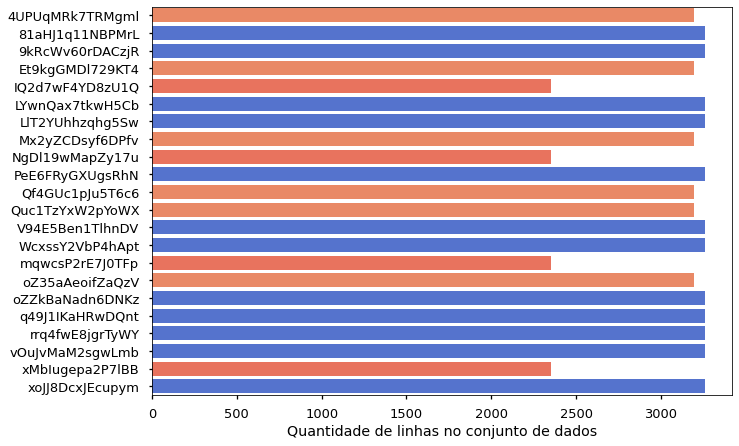

In [21]:
inversor1 = dtUnificadaTrativa3.loc[dtUnificadaTrativa3['SOURCE_KEY'] == '4UPUqMRk7TRMgml']
inversor2 = dtUnificadaTrativa3.loc[dtUnificadaTrativa3['SOURCE_KEY'] == '81aHJ1q11NBPMrL']
inversor3 = dtUnificadaTrativa3.loc[dtUnificadaTrativa3['SOURCE_KEY'] == '9kRcWv60rDACzjR']
inversor4 = dtUnificadaTrativa3.loc[dtUnificadaTrativa3['SOURCE_KEY'] == 'Et9kgGMDl729KT4']
inversor5 = dtUnificadaTrativa3.loc[dtUnificadaTrativa3['SOURCE_KEY'] == 'IQ2d7wF4YD8zU1Q']
inversor6 = dtUnificadaTrativa3.loc[dtUnificadaTrativa3['SOURCE_KEY'] == 'LYwnQax7tkwH5Cb']
inversor7 = dtUnificadaTrativa3.loc[dtUnificadaTrativa3['SOURCE_KEY'] == 'LlT2YUhhzqhg5Sw']
inversor8 = dtUnificadaTrativa3.loc[dtUnificadaTrativa3['SOURCE_KEY'] == 'Mx2yZCDsyf6DPfv']
inversor9 = dtUnificadaTrativa3.loc[dtUnificadaTrativa3['SOURCE_KEY'] == 'NgDl19wMapZy17u']
inversor10 = dtUnificadaTrativa3.loc[dtUnificadaTrativa3['SOURCE_KEY'] == 'PeE6FRyGXUgsRhN']
inversor11 = dtUnificadaTrativa3.loc[dtUnificadaTrativa3['SOURCE_KEY'] == 'Qf4GUc1pJu5T6c6']
inversor12 = dtUnificadaTrativa3.loc[dtUnificadaTrativa3['SOURCE_KEY'] == 'Quc1TzYxW2pYoWX']
inversor13 = dtUnificadaTrativa3.loc[dtUnificadaTrativa3['SOURCE_KEY'] == 'V94E5Ben1TlhnDV']
inversor14 = dtUnificadaTrativa3.loc[dtUnificadaTrativa3['SOURCE_KEY'] == 'WcxssY2VbP4hApt']
inversor15 = dtUnificadaTrativa3.loc[dtUnificadaTrativa3['SOURCE_KEY'] == 'mqwcsP2rE7J0TFp']
inversor16 = dtUnificadaTrativa3.loc[dtUnificadaTrativa3['SOURCE_KEY'] == 'oZ35aAeoifZaQzV']
inversor17 = dtUnificadaTrativa3.loc[dtUnificadaTrativa3['SOURCE_KEY'] == 'oZZkBaNadn6DNKz']
inversor18 = dtUnificadaTrativa3.loc[dtUnificadaTrativa3['SOURCE_KEY'] == 'q49J1IKaHRwDQnt']
inversor19 = dtUnificadaTrativa3.loc[dtUnificadaTrativa3['SOURCE_KEY'] == 'rrq4fwE8jgrTyWY']
inversor20 = dtUnificadaTrativa3.loc[dtUnificadaTrativa3['SOURCE_KEY'] == 'vOuJvMaM2sgwLmb']
inversor21 = dtUnificadaTrativa3.loc[dtUnificadaTrativa3['SOURCE_KEY'] == 'xMbIugepa2P7lBB']
inversor22 = dtUnificadaTrativa3.loc[dtUnificadaTrativa3['SOURCE_KEY'] == 'xoJJ8DcxJEcupym']

inversores = ['4UPUqMRk7TRMgml', '81aHJ1q11NBPMrL', '9kRcWv60rDACzjR', 'Et9kgGMDl729KT4', 'IQ2d7wF4YD8zU1Q', 'LYwnQax7tkwH5Cb', 'LlT2YUhhzqhg5Sw', 'Mx2yZCDsyf6DPfv', 'NgDl19wMapZy17u', 'PeE6FRyGXUgsRhN', 'Qf4GUc1pJu5T6c6', 'Quc1TzYxW2pYoWX', 'V94E5Ben1TlhnDV', 'WcxssY2VbP4hApt', 'mqwcsP2rE7J0TFp', 'oZ35aAeoifZaQzV', 'oZZkBaNadn6DNKz', 'q49J1IKaHRwDQnt', 'rrq4fwE8jgrTyWY', 'vOuJvMaM2sgwLmb', 'xMbIugepa2P7lBB', 'xoJJ8DcxJEcupym']
quantidade_de_linhas = [(inversor1.shape[0]), (inversor2.shape[0]), (inversor3.shape[0]), (inversor4.shape[0]), (inversor5.shape[0]), (inversor6.shape[0]), (inversor7.shape[0]), (inversor8.shape[0]), (inversor9.shape[0]), (inversor10.shape[0]), (inversor11.shape[0]), (inversor12.shape[0]), (inversor13.shape[0]), (inversor14.shape[0]), (inversor15.shape[0]), (inversor16.shape[0]), (inversor17.shape[0]), (inversor18.shape[0]), (inversor19.shape[0]), (inversor20.shape[0]), (inversor21.shape[0]), (inversor22.shape[0])]

cor = ['royalblue' if (inversores == 3259) else 'coral' if (inversores == 3195) else 'tomato' for inversores in quantidade_de_linhas ]
#ordem = ['royalblue', 'coral', 'tomato']

sns.barplot(x=quantidade_de_linhas, y=inversores, palette=cor)
plt.xlabel('Quantidade de linhas no conjunto de dados')
plt.savefig(diretorioImagens + '/qtdlinhasinversores.png', format='png', bbox_inches='tight')
plt.show()

#fig = px.bar(labels={"x": "Quantidade de linhas no conjunto de dados", "y": "Inversor"}, x=quantidade_de_linhas, y=inversores, color=cor, width=800)
#fig.update_yaxes(categoryorder="total ascending")

Analisando o gráfico gerado, percebe-se que nenhum inversor gerou as 3.264 linhas de dados esperadas, no entanto, a maioria (em azul) gerou 3.259 linhas de dados, o que é muito próximo do esperado. Nota-se ainda que houve um padrão em relação ao registro dos dados, sendo 12 inversores com 3.259 linhas de informação, 6 com 3.195 linhas e 4 com 2.355 linhas de dados.

Para a previsão de geração de energia fotovoltaica, serão considerados os 12 inversores que apresentaram uma maior quantidade de linhas de dados para os 34 dias.

In [22]:
# Removendo inversores com menos de 3.259 linhas de dados da amostra
dtUnificadaTrativa4 = dtUnificadaTrativa3.drop(inversor21.index)
dtUnificadaTrativa4 = dtUnificadaTrativa4.drop(inversor15.index)
dtUnificadaTrativa4 = dtUnificadaTrativa4.drop(inversor9.index)
dtUnificadaTrativa4 = dtUnificadaTrativa4.drop(inversor5.index)
dtUnificadaTrativa4 = dtUnificadaTrativa4.drop(inversor16.index)
dtUnificadaTrativa4 = dtUnificadaTrativa4.drop(inversor12.index)
dtUnificadaTrativa4 = dtUnificadaTrativa4.drop(inversor11.index)
dtUnificadaTrativa4 = dtUnificadaTrativa4.drop(inversor8.index)
dtUnificadaTrativa4 = dtUnificadaTrativa4.drop(inversor4.index)
dtUnificadaTrativa4 = dtUnificadaTrativa4.drop(inversor1.index)

dtUnificadaTrativa4.head()

DATE_TIME       SOURCE_KEY  DC_POWER  AC_POWER  DAILY_YIELD   TOTAL_YIELD  \
1 2020-05-15  81aHJ1q11NBPMrL       0.0       0.0     0.000000  1.215279e+09   
2 2020-05-15  9kRcWv60rDACzjR       0.0       0.0  3075.333333  2.247720e+09   
5 2020-05-15  LYwnQax7tkwH5Cb       0.0       0.0  1872.500000  1.794959e+09   
6 2020-05-15  LlT2YUhhzqhg5Sw       0.0       0.0  1094.357143  2.825928e+08   
9 2020-05-15  PeE6FRyGXUgsRhN       0.0       0.0   651.200000  1.348351e+09   

   AMBIENT_TEMPERATURE  MODULE_TEMPERATURE  IRRADIATION  
1            27.004764           25.060789          0.0  
2            27.004764           25.060789          0.0  
5            27.004764           25.060789          0.0  
6            27.004764           25.060789          0.0  
9            27.004764           25.060789          0.0

In [23]:
dtUnificadaTrativa4.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39108 entries, 1 to 67697
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   DATE_TIME            39108 non-null  datetime64[ns]
 1   SOURCE_KEY           39108 non-null  object        
 2   DC_POWER             39108 non-null  float64       
 3   AC_POWER             39108 non-null  float64       
 4   DAILY_YIELD          39108 non-null  float64       
 5   TOTAL_YIELD          39108 non-null  float64       
 6   AMBIENT_TEMPERATURE  39108 non-null  float64       
 7   MODULE_TEMPERATURE   39108 non-null  float64       
 8   IRRADIATION          39108 non-null  float64       
dtypes: datetime64[ns](1), float64(7), object(1)
memory usage: 3.0+ MB


In [24]:
dtUnificadaTrativa4.shape

(39108, 9)

Sendo 12 inversores, cada um registrando informações a cada 15 minutos, se tem que em um período de 6 horas, serão necessários 576 registros de dados. O gráfico a seguir identifica em quais dias não houveram esta quantidade de registro de dados.

Percebe-se que a falta ocorreu nos dias 15, 19 e 29 de maio, e nos dias 1 e 3 de junho.

In [25]:
# Quantidade de registros de potência DC em um período de 6 horas
fig = px.histogram(dtUnificadaTrativa4, labels={"DATE_TIME": "Data"}, x="DATE_TIME")
fig.update_yaxes(title_text='Quantidade de registros de Potência DC')

## 3.2 Potência AC e DC geradas

In [26]:
# Potência AC e DC média gerada em um período de 6 horas
x = dtUnificadaTrativa4["DATE_TIME"]
y1 = dtUnificadaTrativa4["AC_POWER"]
y2 = dtUnificadaTrativa4["DC_POWER"]

layout = go.Layout(
    autosize=False,
    width=800,
    height=250,

    margin=go.layout.Margin(
    l=10,
    r=10,
    b=10,
    t=10,
    pad = 4
)
)

fig = go.Figure(layout = layout)
fig.add_trace(go.Histogram(histfunc="avg", y=y2, x=x, name="Potência DC"))
fig.add_trace(go.Histogram(histfunc="avg", y=y1, x=x, name="Potência AC"))

fig.update_layout(barmode='overlay')
fig.update_traces(opacity=0.5)

fig.update_yaxes(title_text='Potência média (kW)')

fig.write_image(diretorioImagens + '/pot_ac_dc_media.png')

In [27]:
# Potência AC e DC total gerada em um período de 6 horas
x = dtUnificadaTrativa4["DATE_TIME"]
y1 = dtUnificadaTrativa4["AC_POWER"]
y2 = dtUnificadaTrativa4["DC_POWER"]

layout = go.Layout(
    autosize=False,
    width=800,
    height=250,

    margin=go.layout.Margin(
    l=10,
    r=10,
    b=10,
    t=10,
    pad = 4
)
)

fig = go.Figure(layout = layout)
fig.add_trace(go.Histogram(y=y2, x=x, name="Potência DC", histfunc='sum'))
fig.add_trace(go.Histogram(y=y1, x=x, name="Potência AC", histfunc='sum'))

fig.update_layout(barmode='overlay')
fig.update_traces(opacity=0.5)

fig.update_yaxes(title_text='Potência total (kW)')

fig.write_image(diretorioImagens + '/pot_ac_dc_total.png')

Perdas média:  97.81319870457322


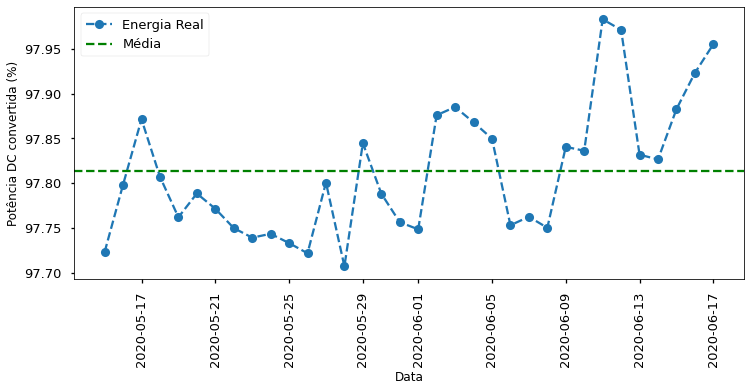

In [28]:
# Perdas na geração de energia
perdas=dtUnificadaTrativa4.copy() # Copia conteúdo da tabela de dados da planta
perdas['data']=perdas['DATE_TIME'].dt.date # Reune os dados de data somente
perdas=perdas.groupby('data').sum() # Agrupa todos os dados para as 34 datas
perdas['perdas']=perdas['AC_POWER']/perdas['DC_POWER']*100 # Reune os dados de energia real convertida

perdas['perdas'].plot(style='o--',figsize=(12,5),label='Energia Real') # Plota os dados de energia real convertida

print('Perdas média: ', perdas['perdas'].mean())

plt.ylabel('Potência DC convertida (%)',fontsize=12)
plt.xlabel('Data',fontsize=12)
plt.axhline(perdas['perdas'].mean(),linestyle='--',color='green',label='Média') # Plota linha com a média dos dados de energia convertida
plt.xticks(rotation = 90)
plt.legend()
plt.savefig(diretorioImagens + '/porcentagemEnergiaConvertida.png', format='png', bbox_inches='tight')
plt.show()

## 3.3 Irradiação

In [123]:
layout = go.Layout(
    autosize=False,
    width=800,
    height=100,

    margin=go.layout.Margin(
    l=0,
    r=0,
    b=0,
    t=0,
    pad = 0
)
)

# Irradiação média gerada em um período de 6 horas
fig = go.Figure(layout = layout)
fig = px.histogram(dtUnificadaTrativa4, labels={"DATE_TIME": "Data"}, x="DATE_TIME", y="IRRADIATION", histfunc='avg')
fig.update_yaxes(title_text='Irradiação média (W/m²)')

fig.write_image(diretorioImagens + '/irradiacao_media.png')

## 3.4 Temperatura

In [29]:
# Temperatura do módulo média gerada em um período de 6 horas
x = dtUnificadaTrativa4["DATE_TIME"]
y1 = dtUnificadaTrativa4["AMBIENT_TEMPERATURE"]
y2 = dtUnificadaTrativa4["MODULE_TEMPERATURE"]

layout = go.Layout(
    autosize=False,
    width=800,
    height=250,

    margin=go.layout.Margin(
    l=10,
    r=10,
    b=10,
    t=10,
    pad = 4
)
)

fig = go.Figure(layout = layout)
fig.add_trace(go.Histogram(histfunc="avg", y=y1, x=x, name="Temp. Ambiente"))
fig.add_trace(go.Histogram(histfunc="avg", y=y2, x=x, name="Temp. Módulo"))

fig.update_layout(barmode='overlay')
fig.update_traces(opacity=0.5)

fig.update_yaxes(title_text='Temperatura média (ºC)')
fig.write_image(diretorioImagens + '/Temperatura_media.png')

## 3.5 Simetria dos Dados

Antes de verificar a simetria das variáveis, serão criados mais dois atributos. Visto que dados de geração de energia solar dependem da sazonalidade, serão criadas as colunas "HOUR" e "DAY", de modo a identificar se estas possuem correlação com o atributo alvo, potência AC.

In [30]:
dtUnificadaTratativa4_1 = dtUnificadaTrativa4.copy()

# Criando colunas de mês, dia e hora
dtUnificadaTratativa4_1['DAY'] = dtUnificadaTratativa4_1['DATE_TIME'].dt.day
dtUnificadaTratativa4_1['HOUR'] = dtUnificadaTratativa4_1['DATE_TIME'].dt.hour

In [31]:
dtUnificadaTratativa4_1

DATE_TIME       SOURCE_KEY  DC_POWER  AC_POWER  DAILY_YIELD  \
1     2020-05-15 00:00:00  81aHJ1q11NBPMrL       0.0       0.0     0.000000   
2     2020-05-15 00:00:00  9kRcWv60rDACzjR       0.0       0.0  3075.333333   
5     2020-05-15 00:00:00  LYwnQax7tkwH5Cb       0.0       0.0  1872.500000   
6     2020-05-15 00:00:00  LlT2YUhhzqhg5Sw       0.0       0.0  1094.357143   
9     2020-05-15 00:00:00  PeE6FRyGXUgsRhN       0.0       0.0   651.200000   
...                   ...              ...       ...       ...          ...   
67692 2020-06-17 23:45:00  oZZkBaNadn6DNKz       0.0       0.0  4389.000000   
67693 2020-06-17 23:45:00  q49J1IKaHRwDQnt       0.0       0.0  4157.000000   
67694 2020-06-17 23:45:00  rrq4fwE8jgrTyWY       0.0       0.0  3931.000000   
67695 2020-06-17 23:45:00  vOuJvMaM2sgwLmb       0.0       0.0  4322.000000   
67697 2020-06-17 23:45:00  xoJJ8DcxJEcupym       0.0       0.0  4316.000000   

        TOTAL_YIELD  AMBIENT_TEMPERATURE  MODULE_TEMPERATURE  IRRADIATION  \
1      1.215279e+09            27.004764           25.060789          0.0   
2      2.247720e+09            27.004764           25.060789          0.0   
5      1.794959e+09            27.004764           25.060789          0.0   
6      2.825928e+08            27.004764           25.060789          0.0   
9      1.348351e+09            27.004764           25.060789          0.0   
...             ...                  ...                 ...          ...   
67692  1.708288e+09            23.202871           22.535908          0.0   
67693  5.207580e+05            23.202871           22.535908          0.0   
67694  1.211314e+08            23.202871           22.535908          0.0   
67695  2.427691e+06            23.202871           22.535908          0.0   
67697  2.093357e+08            23.202871           22.535908          0.0   

       DAY  HOUR  
1       15     0  
2       15     0  
5       15     0  
6       15     0  
9       15     0  
...    ...   ...  
67692   17    23  
67693   17    23  
67694   17    23  
67695   17    23  
67697   17    23  

[39108 rows x 11 columns]

In [32]:
list(dtUnificadaTratativa4_1)

['DATE_TIME',
 'SOURCE_KEY',
 'DC_POWER',
 'AC_POWER',
 'DAILY_YIELD',
 'TOTAL_YIELD',
 'AMBIENT_TEMPERATURE',
 'MODULE_TEMPERATURE',
 'IRRADIATION',
 'DAY',
 'HOUR']

Para uma simetria perfeita, espera-se valores muito próximos de 0.

In [33]:
print(dtUnificadaTratativa4_1.skew(), '\nSoma:', sum(abs(dtUnificadaTratativa4_1.skew())))

DC_POWER               1.403455
AC_POWER               1.397904
DAILY_YIELD            0.595715
TOTAL_YIELD            0.303067
AMBIENT_TEMPERATURE    0.648557
MODULE_TEMPERATURE     0.952207
IRRADIATION            1.061519
DAY                    0.000249
HOUR                   0.002046
dtype: float64 
Soma: 6.36471983797979


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning:

Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.



Os atributos de geração de energia (AC_POWER e DC_POWER) e irradiação apresentam uma simetria acima de zero, isto pode ser devido a calda-longa apresentada pelos histogramas a seguir.

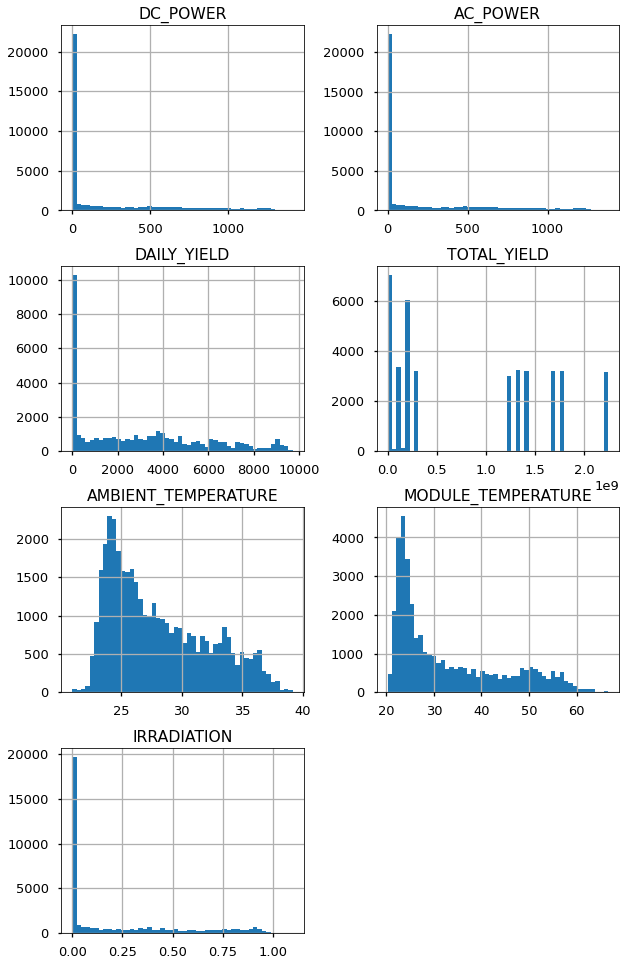

In [34]:
# Gerar um histograma para cada atributo numérico
dtSimetria = dtUnificadaTratativa4_1.drop(['DATE_TIME', 'DAY', 'HOUR'], axis = 1)
dtSimetria.hist(bins=50, figsize=(10,30), layout=(7,2))
plt.savefig(diretorioImagens + '/simetria_1.png', format='png', bbox_inches='tight')
plt.show()

Percebe-se que na variável de geração de energia (AC_POWER) e para a variável de irradiação, se tem uma tail-havy (calda-longa) no valor nulo, isto se dá pois durante a noite não existe irradiação solar e consequentemente não se tem geração de energia.

O gráfico a seguir, mostra que para todos os inversores, no período entre as 19h e 5h, o valor é nulo, logo, não será necessário considerar este intervalo na previsão.

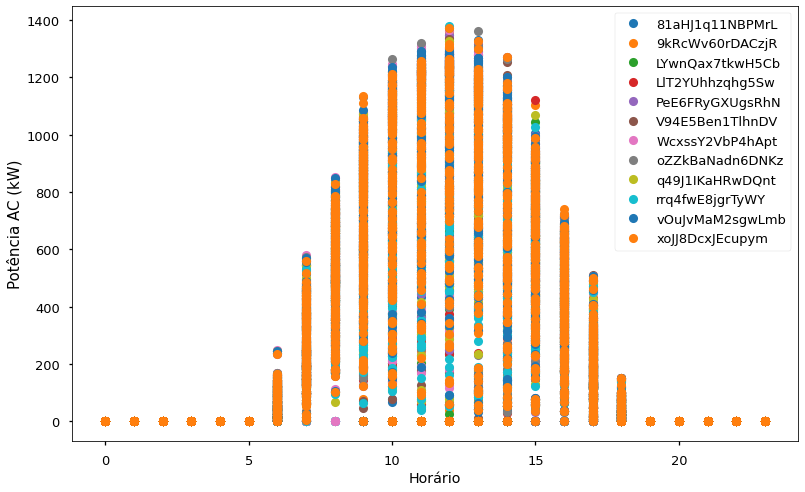

In [121]:
inversores = dtUnificadaTratativa4_1.copy()
inversores['Horário'] = inversores['DATE_TIME'].dt.hour # Retorna um array com os dados de hora
inversores.set_index('Horário').groupby('SOURCE_KEY')['AC_POWER'].plot(style='o', legend=True, figsize=(13,8))

#plt.title('Potência AC Gerada durante o dia para todos os inversores', size=17)
plt.ylabel('Potência AC (kW)', fontsize=15)
plt.legend()
plt.savefig(diretorioImagens + '/energia_AC_total.png', format='png', bbox_inches='tight')
plt.show()

In [36]:
# Removendo intervalo onde a geração de enegia é nula
filtro = (dtUnificadaTratativa4_1['DATE_TIME'].dt.hour > 5) & (dtUnificadaTratativa4_1['DATE_TIME'].dt.hour < 19)

dtUnificadaTratativa4_2 = dtUnificadaTratativa4_1[filtro]

dtUnificadaTratativa4_2.describe()

DC_POWER      AC_POWER   DAILY_YIELD   TOTAL_YIELD  \
count  21168.000000  21168.000000  21168.000000  2.116800e+04   
mean     441.494661    431.801365   2856.320170  8.539280e+08   
std      394.990590    385.817918   2503.592487  7.864847e+08   
min        0.000000      0.000000      0.000000  0.000000e+00   
25%       63.021071     61.007857    725.066667  1.210931e+08   
50%      368.376667    362.023333   2212.000000  2.827648e+08   
75%      731.506667    715.825000   4337.783333  1.412281e+09   
max     1414.120000   1378.766667   9729.000000  2.247916e+09   

       AMBIENT_TEMPERATURE  MODULE_TEMPERATURE   IRRADIATION           DAY  \
count         21168.000000        21168.000000  21168.000000  21168.000000   
mean             30.187215           39.962348      0.429947     16.006803   
std               3.994715           10.987006      0.309534      8.534909   
min              21.567336           21.031937      0.000000      1.000000   
25%              26.876402           30.885584      0.135957      9.000000   
50%              30.039420           38.838420      0.395094     16.000000   
75%              33.493722           49.575120      0.713416     23.000000   
max              39.181638           66.635953      1.098766     31.000000   

               HOUR  
count  21168.000000  
mean      11.991497  
std        3.741357  
min        6.000000  
25%        9.000000  
50%       12.000000  
75%       15.000000  
max       18.000000

In [119]:
inversores = dtUnificadaTratativa4_2.copy()
inversores['Horário'] = inversores['DATE_TIME'].dt.hour # Retorna um array com os dados de hora
inversores.set_index('Horário').groupby('SOURCE_KEY')['AC_POWER'].plot(style='o', legend=True, figsize=(13,10))

plt.ylabel('Potência AC (kW)', fontsize=17)
plt.legend()
plt.savefig(diretorioImagens + '/energia_AC_total_6-18.png', format='png', bbox_inches='tight')
plt.show()

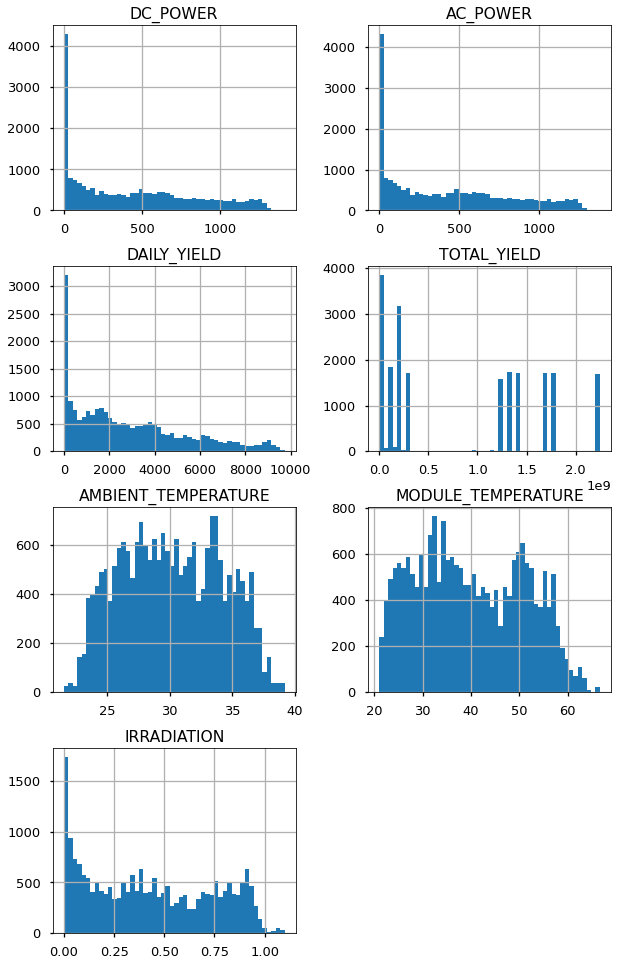

In [38]:
# Gerar um histograma para cada atributo numérico
dtSimetria = dtUnificadaTratativa4_2.drop(['DATE_TIME', 'DAY', 'HOUR'], axis = 1)
dtSimetria.hist(bins=50, figsize=(10,30), layout=(7,2))
plt.savefig(diretorioImagens + '/simetria_2.png', format='png', bbox_inches='tight')
plt.show()

Mesmo removendo o intervalo onde a geração de energia deveria ser nula, percebe-se que os histrogramas ainda apresentam uma calda-longa. O que pode indicar um mau funcionamento dos inversores. Serão reunidos os valores nulos em uma amostra, para identificar o período em que estes ocorrem e se a irradiação possui influência sobre estes valores.

In [39]:
# Reunir os valores nulos de energia
dataframe = dtUnificadaTratativa4_2.copy()
filtro = dtUnificadaTratativa4_2['AC_POWER'] == 0

geracaoACNula = dataframe[filtro]

In [40]:
# Histograma com as quantidade de valores nulos 
diasNulos = geracaoACNula['DATE_TIME'].dt.hour

fig = px.histogram(geracaoACNula, labels={"x": "Data"}, x=diasNulos, y="AC_POWER", histfunc='count')
fig.update_yaxes(title_text='Quantidade de valores nulos durante os 34 dias')

In [124]:
# Histograma com a média de irradiação para quando a geração de energia foi nula
diasNulos = geracaoACNula['DATE_TIME'].dt.hour

layout = go.Layout(
    autosize=False,
    width=800,
    height=250,

    margin=go.layout.Margin(
    l=0,
    r=0,
    b=0,
    t=0,
    pad = 0
)
)

fig = go.Figure(layout = layout)
fig = px.histogram(geracaoACNula, labels={'x': "Hora"}, x=diasNulos, y="IRRADIATION", histfunc='avg')
fig.update_yaxes(title_text='Irradiação solar média para os valores nulos (W/m²)')

fig.write_image(diretorioImagens + '/irradiacao_valores_nulos.png')

Pode-se ver que a irradiação seguiu um padrão normal, ou seja, os valores nulos de geração de energia apresentados entre as 7h e 17h estão incorretos, o que pode indicar um mau funcionamento dos inversores, ou pode ter sido um período em que foi feita alguma manutenção e o sistema foi desligado. Na figura a seguir fica evidente o comportamento inesperado para alguns dos 12 inversores.

Os valores nulos de geração de energia neste intervalo serão substituídos pelo seu valor antecedente, o que irá se aproximar do valor gerado naquele instante.

### 3.5.1 Potência AC gerada para cada um dos 34 dias sem tratamento para nulos

/usr/local/lib/python3.7/dist-packages/pandas/plotting/_matplotlib/tools.py:225: UserWarning:

When passing multiple axes, layout keyword is ignored

/usr/local/lib/python3.7/dist-packages/pandas/plotting/_matplotlib/__init__.py:71: UserWarning:

When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes

/usr/local/lib/python3.7/dist-packages/pandas/plotting/_matplotlib/tools.py:225: UserWarning:

When passing multiple axes, layout keyword is ignored

/usr/local/lib/python3.7/dist-packages/pandas/plotting/_matplotlib/__init__.py:71: UserWarning:

When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes

/usr/local/lib/python3.7/dist-packages/pandas/plotting/_matplotlib/tools.py:225: UserWarning:

When passing multiple axes, layout keyword is ignored

/usr/local/lib/python3.7/dist-packages/pandas/plotting/_matplotlib/__init__.py:71: UserWarning:

When passing multiple axes, sharex 

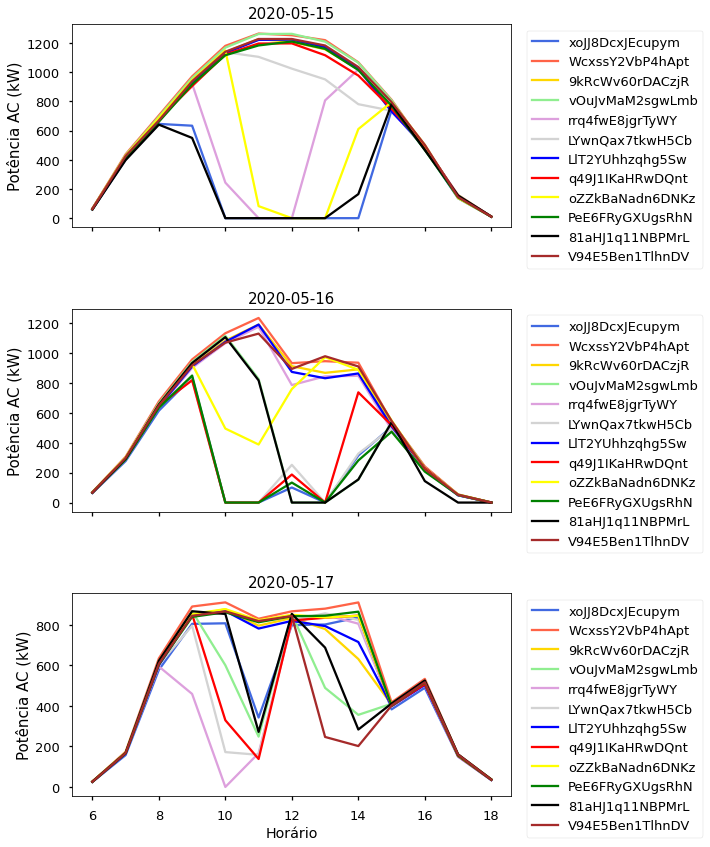

In [42]:
geracao=dtUnificadaTratativa4_2.copy()

geracao['Horário']=geracao['DATE_TIME'].dt.hour
geracao['Data']=geracao['DATE_TIME'].dt.date

# just for columns
cols=geracao.groupby(['Horário','Data'])['AC_POWER'].mean().unstack()

inversores = ['xoJJ8DcxJEcupym', 'WcxssY2VbP4hApt', '9kRcWv60rDACzjR', 'vOuJvMaM2sgwLmb', 'rrq4fwE8jgrTyWY', 'LYwnQax7tkwH5Cb', 'LlT2YUhhzqhg5Sw', 'q49J1IKaHRwDQnt', 'oZZkBaNadn6DNKz', 'PeE6FRyGXUgsRhN', '81aHJ1q11NBPMrL', 'V94E5Ben1TlhnDV']
cores = ['royalblue', 'tomato', 'gold', 'lightgreen', 'plum', 'lightgray', 'blue', 'red', 'yellow', 'green', 'black', 'brown']

inversores3259=dtUnificadaTratativa4_2.loc[dtUnificadaTratativa4_2['SOURCE_KEY']=='xoJJ8DcxJEcupym'].loc[dtUnificadaTratativa4_2['DATE_TIME'] < ('2020-05-18')]
inversores3259['Horário']=inversores3259['DATE_TIME'].dt.hour
inversores3259['Data']=inversores3259['DATE_TIME'].dt.date

ax=inversores3259.groupby(['Horário','Data'])['AC_POWER'].mean().unstack().plot(sharex=True,subplots=True,layout=(3,1),figsize=(10,12), color=cores[0])

j=1
for j in range(1,12):
    inversores3259_2=dtUnificadaTratativa4_2.loc[dtUnificadaTratativa4_2['SOURCE_KEY']==inversores[j]].loc[dtUnificadaTratativa4_2['DATE_TIME'] < ('2020-05-18')]
    inversores3259_2['Horário']=inversores3259_2['DATE_TIME'].dt.hour
    inversores3259_2['Data']=inversores3259_2['DATE_TIME'].dt.date
    inversores3259_2.groupby(['Horário','Data'])['AC_POWER'].mean().unstack().plot(sharex=True,subplots=True,layout=(3,1),figsize=(10,12), color=cores[j], ax=ax)
    j=j+1

i=0
for linha in range(len(ax)):
    for coluna in range(len(ax[linha])):
        ax[linha,coluna].set_title(cols.columns[i],size=15)
        ax[linha,coluna].set_ylabel('Potência AC (kW)', size=15)
        ax[linha,coluna].legend(inversores, bbox_to_anchor = (1.02, 1))
        i=i+1

plt.tight_layout()
plt.savefig(diretorioImagens + '/energia_AC_inversores_com_nulos_1.png', format='png', bbox_inches='tight')
plt.show()

In [43]:
geracao=dtUnificadaTratativa4_2.loc[dtUnificadaTratativa4_2['DATE_TIME'] > ('2020-05-18')].copy()

geracao['Horário']=geracao['DATE_TIME'].dt.hour
geracao['Data']=geracao['DATE_TIME'].dt.date

# just for columns
cols=geracao.groupby(['Horário','Data'])['AC_POWER'].mean().unstack()

inversores = ['xoJJ8DcxJEcupym', 'WcxssY2VbP4hApt', '9kRcWv60rDACzjR', 'vOuJvMaM2sgwLmb', 'rrq4fwE8jgrTyWY', 'LYwnQax7tkwH5Cb', 'LlT2YUhhzqhg5Sw', 'q49J1IKaHRwDQnt', 'oZZkBaNadn6DNKz', 'PeE6FRyGXUgsRhN', '81aHJ1q11NBPMrL', 'V94E5Ben1TlhnDV']
cores = ['royalblue', 'tomato', 'gold', 'lightgreen', 'plum', 'lightgray', 'blue', 'red', 'yellow', 'green', 'black', 'brown']

inversores3259=dtUnificadaTratativa4_2.loc[dtUnificadaTratativa4_2['SOURCE_KEY']=='xoJJ8DcxJEcupym'].loc[(dtUnificadaTratativa4_2['DATE_TIME'] > ('2020-05-18')) & (dtUnificadaTratativa4_2['DATE_TIME'] < ('2020-05-22'))]
inversores3259['Horário']=inversores3259['DATE_TIME'].dt.hour
inversores3259['Data']=inversores3259['DATE_TIME'].dt.date

ax=inversores3259.groupby(['Horário','Data'])['AC_POWER'].mean().unstack().plot(sharex=True,subplots=True,layout=(4,1),figsize=(10,15), color=cores[0])

j=1
for j in range(1,12):
    inversores3259_2=dtUnificadaTratativa4_2.loc[dtUnificadaTratativa4_2['SOURCE_KEY']==inversores[j]].loc[(dtUnificadaTratativa4_2['DATE_TIME'] > ('2020-05-18')) & (dtUnificadaTratativa4_2['DATE_TIME'] < ('2020-05-22'))]
    inversores3259_2['Horário']=inversores3259_2['DATE_TIME'].dt.hour
    inversores3259_2['Data']=inversores3259_2['DATE_TIME'].dt.date
    inversores3259_2.groupby(['Horário','Data'])['AC_POWER'].mean().unstack().plot(sharex=True,subplots=True,layout=(4,1),figsize=(10,15), color=cores[j], ax=ax)
    j=j+1

i=0
for linha in range(len(ax)):
    for coluna in range(len(ax[linha])):
        ax[linha,coluna].set_title(cols.columns[i],size=15)
        ax[linha,coluna].set_ylabel('Potência AC (kW)', size=15)
        ax[linha,coluna].legend(inversores, bbox_to_anchor = (1.02, 1))
        i=i+1

plt.tight_layout()
plt.savefig(diretorioImagens + '/energia_AC_inversores_com_nulos_2.png', format='png', bbox_inches='tight')
plt.show()

/usr/local/lib/python3.7/dist-packages/pandas/plotting/_matplotlib/tools.py:225: UserWarning:

When passing multiple axes, layout keyword is ignored

/usr/local/lib/python3.7/dist-packages/pandas/plotting/_matplotlib/__init__.py:71: UserWarning:

When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes

/usr/local/lib/python3.7/dist-packages/pandas/plotting/_matplotlib/tools.py:225: UserWarning:

When passing multiple axes, layout keyword is ignored

/usr/local/lib/python3.7/dist-packages/pandas/plotting/_matplotlib/__init__.py:71: UserWarning:

When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes

/usr/local/lib/python3.7/dist-packages/pandas/plotting/_matplotlib/tools.py:225: UserWarning:

When passing multiple axes, layout keyword is ignored

/usr/local/lib/python3.7/dist-packages/pandas/plotting/_matplotlib/__init__.py:71: UserWarning:

When passing multiple axes, sharex 

In [44]:
geracao=dtUnificadaTratativa4_2.loc[dtUnificadaTratativa4_2['DATE_TIME'] > ('2020-05-22')].copy()

geracao['Horário']=geracao['DATE_TIME'].dt.hour
geracao['Data']=geracao['DATE_TIME'].dt.date

# just for columns
cols=geracao.groupby(['Horário','Data'])['AC_POWER'].mean().unstack()

inversores = ['xoJJ8DcxJEcupym', 'WcxssY2VbP4hApt', '9kRcWv60rDACzjR', 'vOuJvMaM2sgwLmb', 'rrq4fwE8jgrTyWY', 'LYwnQax7tkwH5Cb', 'LlT2YUhhzqhg5Sw', 'q49J1IKaHRwDQnt', 'oZZkBaNadn6DNKz', 'PeE6FRyGXUgsRhN', '81aHJ1q11NBPMrL', 'V94E5Ben1TlhnDV']
cores = ['royalblue', 'tomato', 'gold', 'lightgreen', 'plum', 'lightgray', 'blue', 'red', 'yellow', 'green', 'black', 'brown']

inversores3259=dtUnificadaTratativa4_2.loc[dtUnificadaTratativa4_2['SOURCE_KEY']=='xoJJ8DcxJEcupym'].loc[(dtUnificadaTratativa4_2['DATE_TIME'] > ('2020-05-22')) & (dtUnificadaTratativa4_2['DATE_TIME'] < ('2020-05-26'))]
inversores3259['Horário']=inversores3259['DATE_TIME'].dt.hour
inversores3259['Data']=inversores3259['DATE_TIME'].dt.date

ax=inversores3259.groupby(['Horário','Data'])['AC_POWER'].mean().unstack().plot(sharex=True,subplots=True,layout=(4,1),figsize=(10,15), color=cores[0])

j=1
for j in range(1,12):
    inversores3259_2=dtUnificadaTratativa4_2.loc[dtUnificadaTratativa4_2['SOURCE_KEY']==inversores[j]].loc[(dtUnificadaTratativa4_2['DATE_TIME'] > ('2020-05-22')) & (dtUnificadaTratativa4_2['DATE_TIME'] < ('2020-05-26'))]
    inversores3259_2['Horário']=inversores3259_2['DATE_TIME'].dt.hour
    inversores3259_2['Data']=inversores3259_2['DATE_TIME'].dt.date
    inversores3259_2.groupby(['Horário','Data'])['AC_POWER'].mean().unstack().plot(sharex=True,subplots=True,layout=(4,1),figsize=(10,15), color=cores[j], ax=ax)
    j=j+1

i=0
for linha in range(len(ax)):
    for coluna in range(len(ax[linha])):
        ax[linha,coluna].set_title(cols.columns[i],size=15)
        ax[linha,coluna].set_ylabel('Potência AC (kW)', size=15)
        ax[linha,coluna].legend(inversores, bbox_to_anchor = (1.02, 1))
        i=i+1

plt.tight_layout()
plt.savefig(diretorioImagens + '/energia_AC_inversores_com_nulos_3.png', format='png', bbox_inches='tight')
plt.show()

/usr/local/lib/python3.7/dist-packages/pandas/plotting/_matplotlib/tools.py:225: UserWarning:

When passing multiple axes, layout keyword is ignored

/usr/local/lib/python3.7/dist-packages/pandas/plotting/_matplotlib/__init__.py:71: UserWarning:

When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes

/usr/local/lib/python3.7/dist-packages/pandas/plotting/_matplotlib/tools.py:225: UserWarning:

When passing multiple axes, layout keyword is ignored

/usr/local/lib/python3.7/dist-packages/pandas/plotting/_matplotlib/__init__.py:71: UserWarning:

When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes

/usr/local/lib/python3.7/dist-packages/pandas/plotting/_matplotlib/tools.py:225: UserWarning:

When passing multiple axes, layout keyword is ignored

/usr/local/lib/python3.7/dist-packages/pandas/plotting/_matplotlib/__init__.py:71: UserWarning:

When passing multiple axes, sharex 

In [45]:
geracao=dtUnificadaTratativa4_2.loc[dtUnificadaTratativa4_2['DATE_TIME'] > ('2020-05-26')].copy()

geracao['Horário']=geracao['DATE_TIME'].dt.hour
geracao['Data']=geracao['DATE_TIME'].dt.date

# just for columns
cols=geracao.groupby(['Horário','Data'])['AC_POWER'].mean().unstack()

inversores = ['xoJJ8DcxJEcupym', 'WcxssY2VbP4hApt', '9kRcWv60rDACzjR', 'vOuJvMaM2sgwLmb', 'rrq4fwE8jgrTyWY', 'LYwnQax7tkwH5Cb', 'LlT2YUhhzqhg5Sw', 'q49J1IKaHRwDQnt', 'oZZkBaNadn6DNKz', 'PeE6FRyGXUgsRhN', '81aHJ1q11NBPMrL', 'V94E5Ben1TlhnDV']
cores = ['royalblue', 'tomato', 'gold', 'lightgreen', 'plum', 'lightgray', 'blue', 'red', 'yellow', 'green', 'black', 'brown']

inversores3259=dtUnificadaTratativa4_2.loc[dtUnificadaTratativa4_2['SOURCE_KEY']=='xoJJ8DcxJEcupym'].loc[(dtUnificadaTratativa4_2['DATE_TIME'] > ('2020-05-26')) & (dtUnificadaTratativa4_2['DATE_TIME'] < ('2020-05-30'))]
inversores3259['Horário']=inversores3259['DATE_TIME'].dt.hour
inversores3259['Data']=inversores3259['DATE_TIME'].dt.date

ax=inversores3259.groupby(['Horário','Data'])['AC_POWER'].mean().unstack().plot(sharex=True,subplots=True,layout=(4,1),figsize=(10,15), color=cores[0])

j=1
for j in range(1,12):
    inversores3259_2=dtUnificadaTratativa4_2.loc[dtUnificadaTratativa4_2['SOURCE_KEY']==inversores[j]].loc[(dtUnificadaTratativa4_2['DATE_TIME'] > ('2020-05-26')) & (dtUnificadaTratativa4_2['DATE_TIME'] < ('2020-05-30'))]
    inversores3259_2['Horário']=inversores3259_2['DATE_TIME'].dt.hour
    inversores3259_2['Data']=inversores3259_2['DATE_TIME'].dt.date
    inversores3259_2.groupby(['Horário','Data'])['AC_POWER'].mean().unstack().plot(sharex=True,subplots=True,layout=(4,1),figsize=(10,15), color=cores[j], ax=ax)
    j=j+1

i=0
for linha in range(len(ax)):
    for coluna in range(len(ax[linha])):
        ax[linha,coluna].set_title(cols.columns[i],size=15)
        ax[linha,coluna].set_ylabel('Potência AC (kW)', size=15)
        ax[linha,coluna].legend(inversores, bbox_to_anchor = (1.02, 1))
        i=i+1

plt.tight_layout()
plt.savefig(diretorioImagens + '/energia_AC_inversores_com_nulos_4.png', format='png', bbox_inches='tight')
plt.show()

/usr/local/lib/python3.7/dist-packages/pandas/plotting/_matplotlib/tools.py:225: UserWarning:

When passing multiple axes, layout keyword is ignored

/usr/local/lib/python3.7/dist-packages/pandas/plotting/_matplotlib/__init__.py:71: UserWarning:

When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes

/usr/local/lib/python3.7/dist-packages/pandas/plotting/_matplotlib/tools.py:225: UserWarning:

When passing multiple axes, layout keyword is ignored

/usr/local/lib/python3.7/dist-packages/pandas/plotting/_matplotlib/__init__.py:71: UserWarning:

When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes

/usr/local/lib/python3.7/dist-packages/pandas/plotting/_matplotlib/tools.py:225: UserWarning:

When passing multiple axes, layout keyword is ignored

/usr/local/lib/python3.7/dist-packages/pandas/plotting/_matplotlib/__init__.py:71: UserWarning:

When passing multiple axes, sharex 

/usr/local/lib/python3.7/dist-packages/pandas/plotting/_matplotlib/tools.py:225: UserWarning:

When passing multiple axes, layout keyword is ignored

/usr/local/lib/python3.7/dist-packages/pandas/plotting/_matplotlib/__init__.py:71: UserWarning:

When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes

/usr/local/lib/python3.7/dist-packages/pandas/plotting/_matplotlib/tools.py:225: UserWarning:

When passing multiple axes, layout keyword is ignored

/usr/local/lib/python3.7/dist-packages/pandas/plotting/_matplotlib/__init__.py:71: UserWarning:

When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes

/usr/local/lib/python3.7/dist-packages/pandas/plotting/_matplotlib/tools.py:225: UserWarning:

When passing multiple axes, layout keyword is ignored

/usr/local/lib/python3.7/dist-packages/pandas/plotting/_matplotlib/__init__.py:71: UserWarning:

When passing multiple axes, sharex 

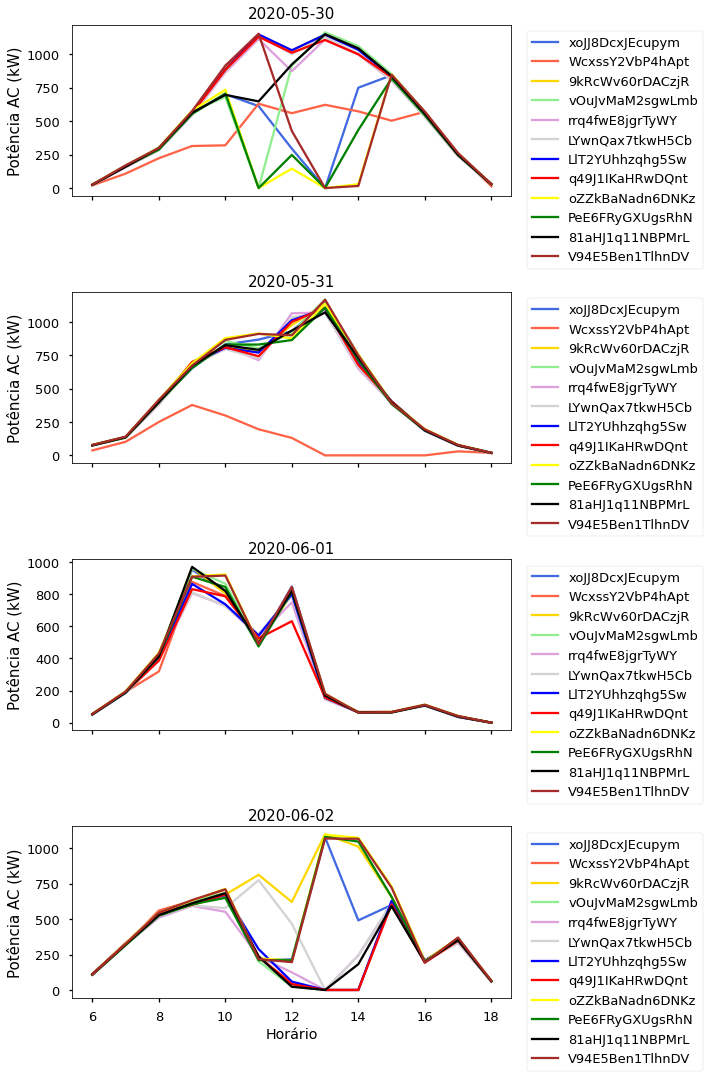

In [46]:
geracao=dtUnificadaTratativa4_2.loc[dtUnificadaTratativa4_2['DATE_TIME'] > ('2020-05-30')].copy()

geracao['Horário']=geracao['DATE_TIME'].dt.hour
geracao['Data']=geracao['DATE_TIME'].dt.date

# just for columns
cols=geracao.groupby(['Horário','Data'])['AC_POWER'].mean().unstack()

inversores = ['xoJJ8DcxJEcupym', 'WcxssY2VbP4hApt', '9kRcWv60rDACzjR', 'vOuJvMaM2sgwLmb', 'rrq4fwE8jgrTyWY', 'LYwnQax7tkwH5Cb', 'LlT2YUhhzqhg5Sw', 'q49J1IKaHRwDQnt', 'oZZkBaNadn6DNKz', 'PeE6FRyGXUgsRhN', '81aHJ1q11NBPMrL', 'V94E5Ben1TlhnDV']
cores = ['royalblue', 'tomato', 'gold', 'lightgreen', 'plum', 'lightgray', 'blue', 'red', 'yellow', 'green', 'black', 'brown']

inversores3259=dtUnificadaTratativa4_2.loc[dtUnificadaTratativa4_2['SOURCE_KEY']=='xoJJ8DcxJEcupym'].loc[(dtUnificadaTratativa4_2['DATE_TIME'] > ('2020-05-30')) & (dtUnificadaTratativa4_2['DATE_TIME'] < ('2020-06-03'))]
inversores3259['Horário']=inversores3259['DATE_TIME'].dt.hour
inversores3259['Data']=inversores3259['DATE_TIME'].dt.date

ax=inversores3259.groupby(['Horário','Data'])['AC_POWER'].mean().unstack().plot(sharex=True,subplots=True,layout=(4,1),figsize=(10,15), color=cores[0])

j=1
for j in range(1,12):
    inversores3259_2=dtUnificadaTratativa4_2.loc[dtUnificadaTratativa4_2['SOURCE_KEY']==inversores[j]].loc[(dtUnificadaTratativa4_2['DATE_TIME'] > ('2020-05-30')) & (dtUnificadaTratativa4_2['DATE_TIME'] < ('2020-06-03'))]
    inversores3259_2['Horário']=inversores3259_2['DATE_TIME'].dt.hour
    inversores3259_2['Data']=inversores3259_2['DATE_TIME'].dt.date
    inversores3259_2.groupby(['Horário','Data'])['AC_POWER'].mean().unstack().plot(sharex=True,subplots=True,layout=(4,1),figsize=(10,15), color=cores[j], ax=ax)
    j=j+1

i=0
for linha in range(len(ax)):
    for coluna in range(len(ax[linha])):
        ax[linha,coluna].set_title(cols.columns[i],size=15)
        ax[linha,coluna].set_ylabel('Potência AC (kW)', size=15)
        ax[linha,coluna].legend(inversores, bbox_to_anchor = (1.02, 1))
        i=i+1

plt.tight_layout()
plt.savefig(diretorioImagens + '/energia_AC_inversores_com_nulos_5.png', format='png', bbox_inches='tight')
plt.show()

/usr/local/lib/python3.7/dist-packages/pandas/plotting/_matplotlib/tools.py:225: UserWarning:

When passing multiple axes, layout keyword is ignored

/usr/local/lib/python3.7/dist-packages/pandas/plotting/_matplotlib/__init__.py:71: UserWarning:

When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes

/usr/local/lib/python3.7/dist-packages/pandas/plotting/_matplotlib/tools.py:225: UserWarning:

When passing multiple axes, layout keyword is ignored

/usr/local/lib/python3.7/dist-packages/pandas/plotting/_matplotlib/__init__.py:71: UserWarning:

When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes

/usr/local/lib/python3.7/dist-packages/pandas/plotting/_matplotlib/tools.py:225: UserWarning:

When passing multiple axes, layout keyword is ignored

/usr/local/lib/python3.7/dist-packages/pandas/plotting/_matplotlib/__init__.py:71: UserWarning:

When passing multiple axes, sharex 

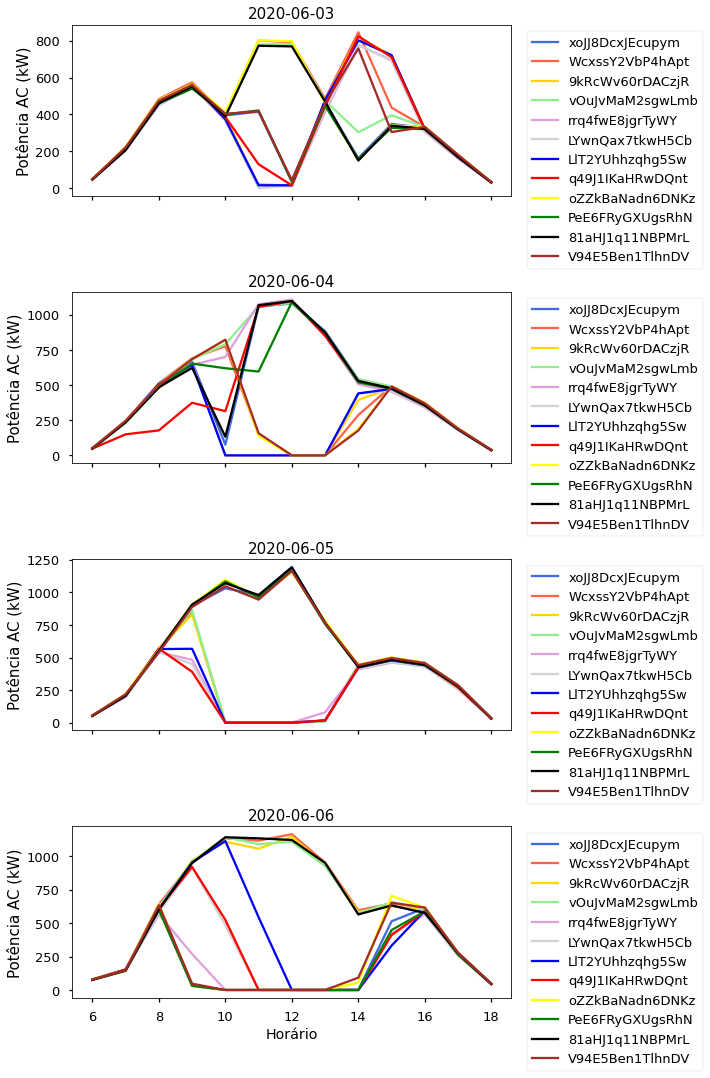

In [47]:
geracao=dtUnificadaTratativa4_2.loc[dtUnificadaTratativa4_2['DATE_TIME'] > ('2020-06-03')].copy()

geracao['Horário']=geracao['DATE_TIME'].dt.hour
geracao['Data']=geracao['DATE_TIME'].dt.date

# just for columns
cols=geracao.groupby(['Horário','Data'])['AC_POWER'].mean().unstack()

inversores = ['xoJJ8DcxJEcupym', 'WcxssY2VbP4hApt', '9kRcWv60rDACzjR', 'vOuJvMaM2sgwLmb', 'rrq4fwE8jgrTyWY', 'LYwnQax7tkwH5Cb', 'LlT2YUhhzqhg5Sw', 'q49J1IKaHRwDQnt', 'oZZkBaNadn6DNKz', 'PeE6FRyGXUgsRhN', '81aHJ1q11NBPMrL', 'V94E5Ben1TlhnDV']
cores = ['royalblue', 'tomato', 'gold', 'lightgreen', 'plum', 'lightgray', 'blue', 'red', 'yellow', 'green', 'black', 'brown']

inversores3259=dtUnificadaTratativa4_2.loc[dtUnificadaTratativa4_2['SOURCE_KEY']=='xoJJ8DcxJEcupym'].loc[(dtUnificadaTratativa4_2['DATE_TIME'] > ('2020-06-03')) & (dtUnificadaTratativa4_2['DATE_TIME'] < ('2020-06-07'))]
inversores3259['Horário']=inversores3259['DATE_TIME'].dt.hour
inversores3259['Data']=inversores3259['DATE_TIME'].dt.date

ax=inversores3259.groupby(['Horário','Data'])['AC_POWER'].mean().unstack().plot(sharex=True,subplots=True,layout=(4,1),figsize=(10,15), color=cores[0])

j=1
for j in range(1,12):
    inversores3259_2=dtUnificadaTratativa4_2.loc[dtUnificadaTratativa4_2['SOURCE_KEY']==inversores[j]].loc[(dtUnificadaTratativa4_2['DATE_TIME'] > ('2020-06-03')) & (dtUnificadaTratativa4_2['DATE_TIME'] < ('2020-06-07'))]
    inversores3259_2['Horário']=inversores3259_2['DATE_TIME'].dt.hour
    inversores3259_2['Data']=inversores3259_2['DATE_TIME'].dt.date
    inversores3259_2.groupby(['Horário','Data'])['AC_POWER'].mean().unstack().plot(sharex=True,subplots=True,layout=(4,1),figsize=(10,15), color=cores[j], ax=ax)
    j=j+1

i=0
for linha in range(len(ax)):
    for coluna in range(len(ax[linha])):
        ax[linha,coluna].set_title(cols.columns[i],size=15)
        ax[linha,coluna].set_ylabel('Potência AC (kW)', size=15)
        ax[linha,coluna].legend(inversores, bbox_to_anchor = (1.02, 1))
        i=i+1

plt.tight_layout()
plt.savefig(diretorioImagens + '/energia_AC_inversores_com_nulos_6.png', format='png', bbox_inches='tight')
plt.show()

/usr/local/lib/python3.7/dist-packages/pandas/plotting/_matplotlib/tools.py:225: UserWarning:

When passing multiple axes, layout keyword is ignored

/usr/local/lib/python3.7/dist-packages/pandas/plotting/_matplotlib/__init__.py:71: UserWarning:

When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes

/usr/local/lib/python3.7/dist-packages/pandas/plotting/_matplotlib/tools.py:225: UserWarning:

When passing multiple axes, layout keyword is ignored

/usr/local/lib/python3.7/dist-packages/pandas/plotting/_matplotlib/__init__.py:71: UserWarning:

When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes

/usr/local/lib/python3.7/dist-packages/pandas/plotting/_matplotlib/tools.py:225: UserWarning:

When passing multiple axes, layout keyword is ignored

/usr/local/lib/python3.7/dist-packages/pandas/plotting/_matplotlib/__init__.py:71: UserWarning:

When passing multiple axes, sharex 

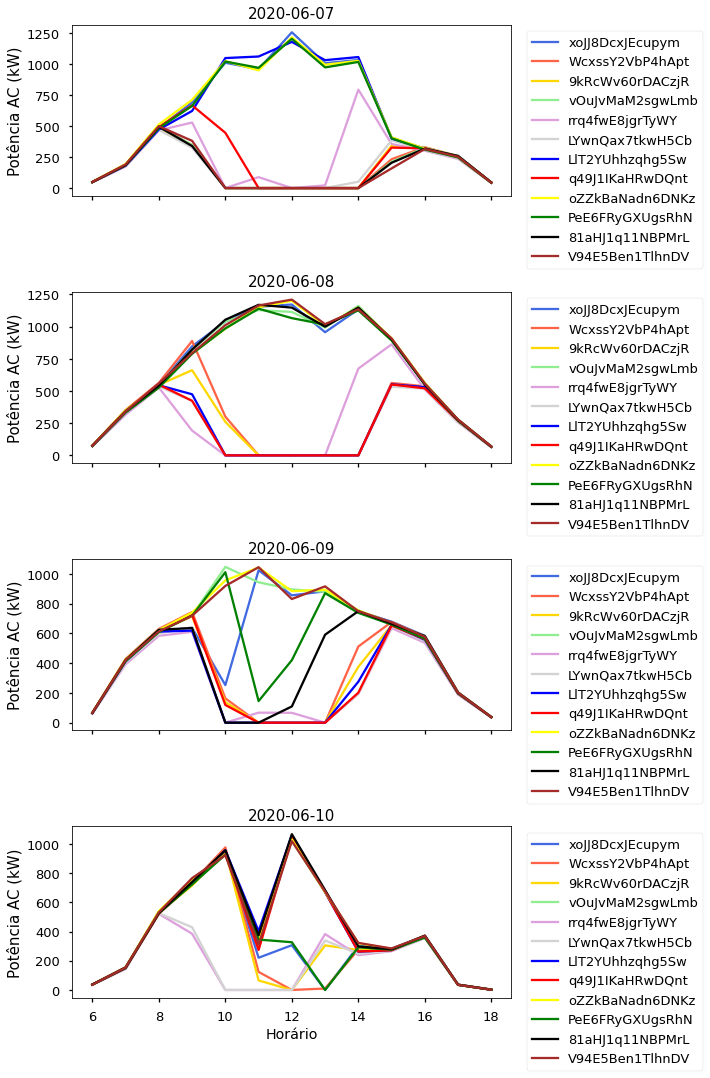

In [48]:
geracao=dtUnificadaTratativa4_2.loc[dtUnificadaTratativa4_2['DATE_TIME'] > ('2020-06-07')].copy()

geracao['Horário']=geracao['DATE_TIME'].dt.hour
geracao['Data']=geracao['DATE_TIME'].dt.date

# just for columns
cols=geracao.groupby(['Horário','Data'])['AC_POWER'].mean().unstack()

inversores = ['xoJJ8DcxJEcupym', 'WcxssY2VbP4hApt', '9kRcWv60rDACzjR', 'vOuJvMaM2sgwLmb', 'rrq4fwE8jgrTyWY', 'LYwnQax7tkwH5Cb', 'LlT2YUhhzqhg5Sw', 'q49J1IKaHRwDQnt', 'oZZkBaNadn6DNKz', 'PeE6FRyGXUgsRhN', '81aHJ1q11NBPMrL', 'V94E5Ben1TlhnDV']
cores = ['royalblue', 'tomato', 'gold', 'lightgreen', 'plum', 'lightgray', 'blue', 'red', 'yellow', 'green', 'black', 'brown']

inversores3259=dtUnificadaTratativa4_2.loc[dtUnificadaTratativa4_2['SOURCE_KEY']=='xoJJ8DcxJEcupym'].loc[(dtUnificadaTratativa4_2['DATE_TIME'] > ('2020-06-07')) & (dtUnificadaTratativa4_2['DATE_TIME'] < ('2020-06-11'))]
inversores3259['Horário']=inversores3259['DATE_TIME'].dt.hour
inversores3259['Data']=inversores3259['DATE_TIME'].dt.date

ax=inversores3259.groupby(['Horário','Data'])['AC_POWER'].mean().unstack().plot(sharex=True,subplots=True,layout=(4,1),figsize=(10,15), color=cores[0])

j=1
for j in range(1,12):
    inversores3259_2=dtUnificadaTratativa4_2.loc[dtUnificadaTratativa4_2['SOURCE_KEY']==inversores[j]].loc[(dtUnificadaTratativa4_2['DATE_TIME'] > ('2020-06-07')) & (dtUnificadaTratativa4_2['DATE_TIME'] < ('2020-06-11'))]
    inversores3259_2['Horário']=inversores3259_2['DATE_TIME'].dt.hour
    inversores3259_2['Data']=inversores3259_2['DATE_TIME'].dt.date
    inversores3259_2.groupby(['Horário','Data'])['AC_POWER'].mean().unstack().plot(sharex=True,subplots=True,layout=(4,1),figsize=(10,15), color=cores[j], ax=ax)
    j=j+1

i=0
for linha in range(len(ax)):
    for coluna in range(len(ax[linha])):
        ax[linha,coluna].set_title(cols.columns[i],size=15)
        ax[linha,coluna].set_ylabel('Potência AC (kW)', size=15)
        ax[linha,coluna].legend(inversores, bbox_to_anchor = (1.02, 1))
        i=i+1

plt.tight_layout()
plt.savefig(diretorioImagens + '/\energia_AC_inversores_com_nulos_7.png', format='png', bbox_inches='tight')
plt.show()

/usr/local/lib/python3.7/dist-packages/pandas/plotting/_matplotlib/tools.py:225: UserWarning:

When passing multiple axes, layout keyword is ignored

/usr/local/lib/python3.7/dist-packages/pandas/plotting/_matplotlib/__init__.py:71: UserWarning:

When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes

/usr/local/lib/python3.7/dist-packages/pandas/plotting/_matplotlib/tools.py:225: UserWarning:

When passing multiple axes, layout keyword is ignored

/usr/local/lib/python3.7/dist-packages/pandas/plotting/_matplotlib/__init__.py:71: UserWarning:

When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes

/usr/local/lib/python3.7/dist-packages/pandas/plotting/_matplotlib/tools.py:225: UserWarning:

When passing multiple axes, layout keyword is ignored

/usr/local/lib/python3.7/dist-packages/pandas/plotting/_matplotlib/__init__.py:71: UserWarning:

When passing multiple axes, sharex 

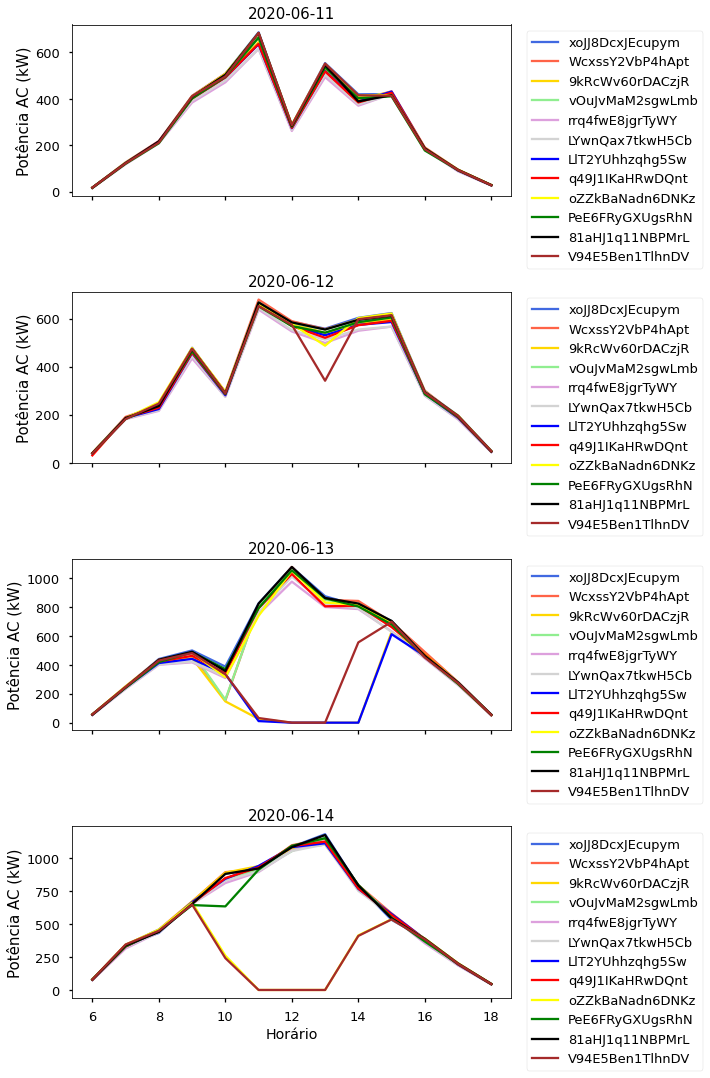

In [49]:
geracao=dtUnificadaTratativa4_2.loc[dtUnificadaTratativa4_2['DATE_TIME'] > ('2020-06-11')].copy()

geracao['Horário']=geracao['DATE_TIME'].dt.hour
geracao['Data']=geracao['DATE_TIME'].dt.date

# just for columns
cols=geracao.groupby(['Horário','Data'])['AC_POWER'].mean().unstack()

inversores = ['xoJJ8DcxJEcupym', 'WcxssY2VbP4hApt', '9kRcWv60rDACzjR', 'vOuJvMaM2sgwLmb', 'rrq4fwE8jgrTyWY', 'LYwnQax7tkwH5Cb', 'LlT2YUhhzqhg5Sw', 'q49J1IKaHRwDQnt', 'oZZkBaNadn6DNKz', 'PeE6FRyGXUgsRhN', '81aHJ1q11NBPMrL', 'V94E5Ben1TlhnDV']
cores = ['royalblue', 'tomato', 'gold', 'lightgreen', 'plum', 'lightgray', 'blue', 'red', 'yellow', 'green', 'black', 'brown']

inversores3259=dtUnificadaTratativa4_2.loc[dtUnificadaTratativa4_2['SOURCE_KEY']=='xoJJ8DcxJEcupym'].loc[(dtUnificadaTratativa4_2['DATE_TIME'] > ('2020-06-11')) & (dtUnificadaTratativa4_2['DATE_TIME'] < ('2020-06-15'))]
inversores3259['Horário']=inversores3259['DATE_TIME'].dt.hour
inversores3259['Data']=inversores3259['DATE_TIME'].dt.date

ax=inversores3259.groupby(['Horário','Data'])['AC_POWER'].mean().unstack().plot(sharex=True,subplots=True,layout=(4,1),figsize=(10,15), color=cores[0])

j=1
for j in range(1,12):
    inversores3259_2=dtUnificadaTratativa4_2.loc[dtUnificadaTratativa4_2['SOURCE_KEY']==inversores[j]].loc[(dtUnificadaTratativa4_2['DATE_TIME'] > ('2020-06-11')) & (dtUnificadaTratativa4_2['DATE_TIME'] < ('2020-06-15'))]
    inversores3259_2['Horário']=inversores3259_2['DATE_TIME'].dt.hour
    inversores3259_2['Data']=inversores3259_2['DATE_TIME'].dt.date
    inversores3259_2.groupby(['Horário','Data'])['AC_POWER'].mean().unstack().plot(sharex=True,subplots=True,layout=(4,1),figsize=(10,15), color=cores[j], ax=ax)
    j=j+1

i=0
for linha in range(len(ax)):
    for coluna in range(len(ax[linha])):
        ax[linha,coluna].set_title(cols.columns[i],size=15)
        ax[linha,coluna].set_ylabel('Potência AC (kW)', size=15)
        ax[linha,coluna].legend(inversores, bbox_to_anchor = (1.02, 1))
        i=i+1

plt.tight_layout()
plt.savefig(diretorioImagens + '/energia_AC_inversores_com_nulos_8.png', format='png', bbox_inches='tight')
plt.show()

/usr/local/lib/python3.7/dist-packages/pandas/plotting/_matplotlib/tools.py:225: UserWarning:

When passing multiple axes, layout keyword is ignored

/usr/local/lib/python3.7/dist-packages/pandas/plotting/_matplotlib/__init__.py:71: UserWarning:

When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes

/usr/local/lib/python3.7/dist-packages/pandas/plotting/_matplotlib/tools.py:225: UserWarning:

When passing multiple axes, layout keyword is ignored

/usr/local/lib/python3.7/dist-packages/pandas/plotting/_matplotlib/__init__.py:71: UserWarning:

When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes

/usr/local/lib/python3.7/dist-packages/pandas/plotting/_matplotlib/tools.py:225: UserWarning:

When passing multiple axes, layout keyword is ignored

/usr/local/lib/python3.7/dist-packages/pandas/plotting/_matplotlib/__init__.py:71: UserWarning:

When passing multiple axes, sharex 

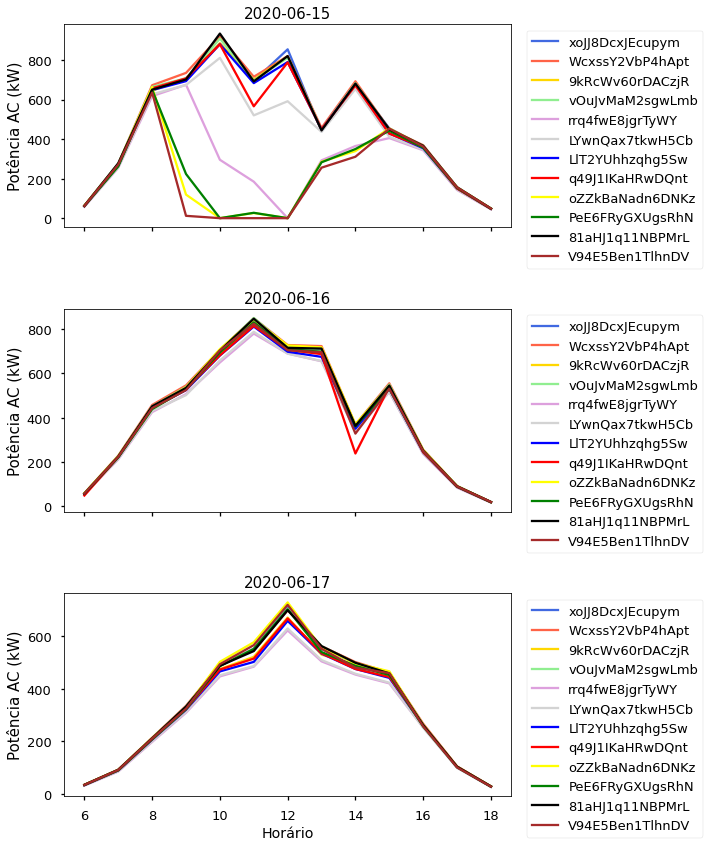

In [50]:
geracao=dtUnificadaTratativa4_2.loc[dtUnificadaTratativa4_2['DATE_TIME'] > ('2020-06-15')].copy()

geracao['Horário']=geracao['DATE_TIME'].dt.hour
geracao['Data']=geracao['DATE_TIME'].dt.date

# just for columns
cols=geracao.groupby(['Horário','Data'])['AC_POWER'].mean().unstack()

inversores = ['xoJJ8DcxJEcupym', 'WcxssY2VbP4hApt', '9kRcWv60rDACzjR', 'vOuJvMaM2sgwLmb', 'rrq4fwE8jgrTyWY', 'LYwnQax7tkwH5Cb', 'LlT2YUhhzqhg5Sw', 'q49J1IKaHRwDQnt', 'oZZkBaNadn6DNKz', 'PeE6FRyGXUgsRhN', '81aHJ1q11NBPMrL', 'V94E5Ben1TlhnDV']
cores = ['royalblue', 'tomato', 'gold', 'lightgreen', 'plum', 'lightgray', 'blue', 'red', 'yellow', 'green', 'black', 'brown']

inversores3259=dtUnificadaTratativa4_2.loc[dtUnificadaTratativa4_2['SOURCE_KEY']=='xoJJ8DcxJEcupym'].loc[(dtUnificadaTratativa4_2['DATE_TIME'] > ('2020-06-15')) & (dtUnificadaTratativa4_2['DATE_TIME'] < ('2020-06-18'))]
inversores3259['Horário']=inversores3259['DATE_TIME'].dt.hour
inversores3259['Data']=inversores3259['DATE_TIME'].dt.date

ax=inversores3259.groupby(['Horário','Data'])['AC_POWER'].mean().unstack().plot(sharex=True,subplots=True,layout=(3,1),figsize=(10,12), color=cores[0])

j=1
for j in range(1,12):
    inversores3259_2=dtUnificadaTratativa4_2.loc[dtUnificadaTratativa4_2['SOURCE_KEY']==inversores[j]].loc[(dtUnificadaTratativa4_2['DATE_TIME'] > ('2020-06-15')) & (dtUnificadaTratativa4_2['DATE_TIME'] < ('2020-06-18'))]
    inversores3259_2['Horário']=inversores3259_2['DATE_TIME'].dt.hour
    inversores3259_2['Data']=inversores3259_2['DATE_TIME'].dt.date
    inversores3259_2.groupby(['Horário','Data'])['AC_POWER'].mean().unstack().plot(sharex=True,subplots=True,layout=(3,1),figsize=(10,12), color=cores[j], ax=ax)
    j=j+1

i=0
for linha in range(len(ax)):
    for coluna in range(len(ax[linha])):
        ax[linha,coluna].set_title(cols.columns[i],size=15)
        ax[linha,coluna].set_ylabel('Potência AC (kW)', size=15)
        ax[linha,coluna].legend(inversores, bbox_to_anchor = (1.02, 1))
        i=i+1

plt.tight_layout()
plt.savefig(diretorioImagens + '/energia_AC_inversores_com_nulos_9.png', format='png', bbox_inches='tight')
plt.show()

### 3.5.2 Tratamento para nulos

In [51]:
# Coletar amostra no intervalo das 7h às 17h
filtro = (dtUnificadaTratativa4_2['DATE_TIME'].dt.hour >= 7) & (dtUnificadaTratativa4_2['DATE_TIME'].dt.hour <= 17)

dtGeracaoACIncorreta = dtUnificadaTratativa4_2[filtro]

In [52]:
# Histograma com a média de irradiação para quando a geração de energia foi nula incorretamente
diasNulos = dtGeracaoACIncorreta['DATE_TIME'].dt.hour

fig = px.histogram(dtGeracaoACIncorreta, labels={'x': "Hora"}, x=diasNulos, y="IRRADIATION", histfunc='avg')
fig.update_yaxes(title_text='Irradiação solar média')

In [53]:
# Substituir valores nulos por NaN
dtGeracaoACIncorretaNAN = dtGeracaoACIncorreta.copy()
geracaoACIncorretaNAN = dtGeracaoACIncorretaNAN[['AC_POWER', 'DC_POWER']].replace(0, np.nan)

# Exibe a quantidade de valores NaN
geracaoACIncorretaNAN.isnull().sum()

AC_POWER    2630
DC_POWER    2630
dtype: int64

In [54]:
dtGeracaoACIncorretaNAN

DATE_TIME       SOURCE_KEY    DC_POWER    AC_POWER  \
617   2020-05-15 07:00:00  81aHJ1q11NBPMrL  292.160000  286.893333   
618   2020-05-15 07:00:00  9kRcWv60rDACzjR  312.493333  307.033333   
621   2020-05-15 07:00:00  LYwnQax7tkwH5Cb  314.906667  309.426667   
622   2020-05-15 07:00:00  LlT2YUhhzqhg5Sw  310.453333  304.993333   
625   2020-05-15 07:00:00  PeE6FRyGXUgsRhN  300.180000  294.853333   
...                   ...              ...         ...         ...   
67164 2020-06-17 17:45:00  oZZkBaNadn6DNKz   99.440000   96.620000   
67165 2020-06-17 17:45:00  q49J1IKaHRwDQnt   97.480000   94.700000   
67166 2020-06-17 17:45:00  rrq4fwE8jgrTyWY   92.320000   89.680000   
67167 2020-06-17 17:45:00  vOuJvMaM2sgwLmb   99.493333   96.693333   
67169 2020-06-17 17:45:00  xoJJ8DcxJEcupym   99.233333   96.413333   

       DAILY_YIELD   TOTAL_YIELD  AMBIENT_TEMPERATURE  MODULE_TEMPERATURE  \
617      91.866667  1.215279e+09            25.673202           28.674707   
618     100.733333  2.247720e+09            25.673202           28.674707   
621     101.466667  1.794959e+09            25.673202           28.674707   
622      99.666667  2.825929e+08            25.673202           28.674707   
625      93.800000  1.348351e+09            25.673202           28.674707   
...            ...           ...                  ...                 ...   
67164  4348.466667  1.708288e+09            26.091664           27.235657   
67165  4116.400000  5.207174e+05            26.091664           27.235657   
67166  3892.466667  1.211313e+08            26.091664           27.235657   
67167  4280.466667  2.427649e+06            26.091664           27.235657   
67169  4274.533333  2.093357e+08            26.091664           27.235657   

       IRRADIATION  DAY  HOUR  
617        0.19945   15     7  
618        0.19945   15     7  
621        0.19945   15     7  
622        0.19945   15     7  
625        0.19945   15     7  
...            ...  ...   ...  
67164      0.06548   17    17  
67165      0.06548   17    17  
67166      0.06548   17    17  
67167      0.06548   17    17  
67169      0.06548   17    17  

[17904 rows x 11 columns]

In [55]:
geracaoACIncorretaNAN.head(1000)

AC_POWER    DC_POWER
617   286.893333  292.160000
618   307.033333  312.493333
621   309.426667  314.906667
622   304.993333  310.453333
625   294.853333  300.180000
...          ...         ...
3563  154.480000  158.013333
3565         NaN         NaN
3566  104.293333  107.140000
3569  100.513333  103.286667
3570  100.860000  103.640000

[1000 rows x 2 columns]

In [56]:
# Substituindo valor NaN com o valor seguinte AC
newColumnAC = geracaoACIncorretaNAN['AC_POWER'].fillna(method='bfill')
newColumnDC = geracaoACIncorretaNAN['DC_POWER'].fillna(method='bfill')

newColumnAC.head(1000)

617     286.893333
618     307.033333
621     309.426667
622     304.993333
625     294.853333
           ...    
3563    154.480000
3565    104.293333
3566    104.293333
3569    100.513333
3570    100.860000
Name: AC_POWER, Length: 1000, dtype: float64

In [57]:
newColumnDC.head(1000)

617     292.160000
618     312.493333
621     314.906667
622     310.453333
625     300.180000
           ...    
3563    158.013333
3565    107.140000
3566    107.140000
3569    103.286667
3570    103.640000
Name: DC_POWER, Length: 1000, dtype: float64

In [58]:
# Substitui a coluna com valor nulo pela coluna com valor numérico
dtGeracaoACCorrigida = dtGeracaoACIncorreta.copy()

# Retira a coluna de geração incorreta
dtGeracaoACCorrigida = dtGeracaoACCorrigida.drop(['AC_POWER', 'DC_POWER'], axis = 1)

# Insere a coluna de geração corrigida na amostra
dtGeracaoACCorrigida['AC_POWER'] = newColumnAC
dtGeracaoACCorrigida['DC_POWER'] = newColumnDC

dtGeracaoACCorrigida.head(1000)

DATE_TIME       SOURCE_KEY  DAILY_YIELD   TOTAL_YIELD  \
617  2020-05-15 07:00:00  81aHJ1q11NBPMrL    91.866667  1.215279e+09   
618  2020-05-15 07:00:00  9kRcWv60rDACzjR   100.733333  2.247720e+09   
621  2020-05-15 07:00:00  LYwnQax7tkwH5Cb   101.466667  1.794959e+09   
622  2020-05-15 07:00:00  LlT2YUhhzqhg5Sw    99.666667  2.825929e+08   
625  2020-05-15 07:00:00  PeE6FRyGXUgsRhN    93.800000  1.348351e+09   
...                  ...              ...          ...           ...   
3563 2020-05-16 16:30:00  xoJJ8DcxJEcupym  2906.666667  2.091496e+08   
3565 2020-05-16 16:45:00  81aHJ1q11NBPMrL     0.000000  0.000000e+00   
3566 2020-05-16 16:45:00  9kRcWv60rDACzjR  7609.600000  2.247736e+09   
3569 2020-05-16 16:45:00  LYwnQax7tkwH5Cb  3109.533333  1.794970e+09   
3570 2020-05-16 16:45:00  LlT2YUhhzqhg5Sw  7475.200000  2.826095e+08   

      AMBIENT_TEMPERATURE  MODULE_TEMPERATURE  IRRADIATION  DAY  HOUR  \
617             25.673202           28.674707     0.199450   15     7   
618             25.673202           28.674707     0.199450   15     7   
621             25.673202           28.674707     0.199450   15     7   
622             25.673202           28.674707     0.199450   15     7   
625             25.673202           28.674707     0.199450   15     7   
...                   ...                 ...          ...  ...   ...   
3563            33.260399           37.332077     0.116788   16    16   
3565            31.583788           33.569140     0.066966   16    16   
3566            31.583788           33.569140     0.066966   16    16   
3569            31.583788           33.569140     0.066966   16    16   
3570            31.583788           33.569140     0.066966   16    16   

        AC_POWER    DC_POWER  
617   286.893333  292.160000  
618   307.033333  312.493333  
621   309.426667  314.906667  
622   304.993333  310.453333  
625   294.853333  300.180000  
...          ...         ...  
3563  154.480000  158.013333  
3565  104.293333  107.140000  
3566  104.293333  107.140000  
3569  100.513333  103.286667  
3570  100.860000  103.640000  

[1000 rows x 11 columns]

In [59]:
dtGeracaoACCorrigida.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17904 entries, 617 to 67169
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   DATE_TIME            17904 non-null  datetime64[ns]
 1   SOURCE_KEY           17904 non-null  object        
 2   DAILY_YIELD          17904 non-null  float64       
 3   TOTAL_YIELD          17904 non-null  float64       
 4   AMBIENT_TEMPERATURE  17904 non-null  float64       
 5   MODULE_TEMPERATURE   17904 non-null  float64       
 6   IRRADIATION          17904 non-null  float64       
 7   DAY                  17904 non-null  int64         
 8   HOUR                 17904 non-null  int64         
 9   AC_POWER             17904 non-null  float64       
 10  DC_POWER             17904 non-null  float64       
dtypes: datetime64[ns](1), float64(7), int64(2), object(1)
memory usage: 1.6+ MB


In [60]:
dtGeracaoACCorrigida

DATE_TIME       SOURCE_KEY  DAILY_YIELD   TOTAL_YIELD  \
617   2020-05-15 07:00:00  81aHJ1q11NBPMrL    91.866667  1.215279e+09   
618   2020-05-15 07:00:00  9kRcWv60rDACzjR   100.733333  2.247720e+09   
621   2020-05-15 07:00:00  LYwnQax7tkwH5Cb   101.466667  1.794959e+09   
622   2020-05-15 07:00:00  LlT2YUhhzqhg5Sw    99.666667  2.825929e+08   
625   2020-05-15 07:00:00  PeE6FRyGXUgsRhN    93.800000  1.348351e+09   
...                   ...              ...          ...           ...   
67164 2020-06-17 17:45:00  oZZkBaNadn6DNKz  4348.466667  1.708288e+09   
67165 2020-06-17 17:45:00  q49J1IKaHRwDQnt  4116.400000  5.207174e+05   
67166 2020-06-17 17:45:00  rrq4fwE8jgrTyWY  3892.466667  1.211313e+08   
67167 2020-06-17 17:45:00  vOuJvMaM2sgwLmb  4280.466667  2.427649e+06   
67169 2020-06-17 17:45:00  xoJJ8DcxJEcupym  4274.533333  2.093357e+08   

       AMBIENT_TEMPERATURE  MODULE_TEMPERATURE  IRRADIATION  DAY  HOUR  \
617              25.673202           28.674707      0.19945   15     7   
618              25.673202           28.674707      0.19945   15     7   
621              25.673202           28.674707      0.19945   15     7   
622              25.673202           28.674707      0.19945   15     7   
625              25.673202           28.674707      0.19945   15     7   
...                    ...                 ...          ...  ...   ...   
67164            26.091664           27.235657      0.06548   17    17   
67165            26.091664           27.235657      0.06548   17    17   
67166            26.091664           27.235657      0.06548   17    17   
67167            26.091664           27.235657      0.06548   17    17   
67169            26.091664           27.235657      0.06548   17    17   

         AC_POWER    DC_POWER  
617    286.893333  292.160000  
618    307.033333  312.493333  
621    309.426667  314.906667  
622    304.993333  310.453333  
625    294.853333  300.180000  
...           ...         ...  
67164   96.620000   99.440000  
67165   94.700000   97.480000  
67166   89.680000   92.320000  
67167   96.693333   99.493333  
67169   96.413333   99.233333  

[17904 rows x 11 columns]

In [61]:
dtUnificadaTratativa4_2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21168 entries, 529 to 67257
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   DATE_TIME            21168 non-null  datetime64[ns]
 1   SOURCE_KEY           21168 non-null  object        
 2   DC_POWER             21168 non-null  float64       
 3   AC_POWER             21168 non-null  float64       
 4   DAILY_YIELD          21168 non-null  float64       
 5   TOTAL_YIELD          21168 non-null  float64       
 6   AMBIENT_TEMPERATURE  21168 non-null  float64       
 7   MODULE_TEMPERATURE   21168 non-null  float64       
 8   IRRADIATION          21168 non-null  float64       
 9   DAY                  21168 non-null  int64         
 10  HOUR                 21168 non-null  int64         
dtypes: datetime64[ns](1), float64(7), int64(2), object(1)
memory usage: 2.4+ MB


In [62]:
dtUnificadaTratativa4_2

DATE_TIME       SOURCE_KEY   DC_POWER   AC_POWER  DAILY_YIELD  \
529   2020-05-15 06:00:00  81aHJ1q11NBPMrL  14.773333  14.246667     0.733333   
530   2020-05-15 06:00:00  9kRcWv60rDACzjR  15.380000  14.840000     1.866667   
533   2020-05-15 06:00:00  LYwnQax7tkwH5Cb  15.566667  15.020000     1.266667   
534   2020-05-15 06:00:00  LlT2YUhhzqhg5Sw  15.180000  14.673333     1.066667   
537   2020-05-15 06:00:00  PeE6FRyGXUgsRhN  14.506667  13.993333     0.666667   
...                   ...              ...        ...        ...          ...   
67252 2020-06-17 18:45:00  oZZkBaNadn6DNKz   3.714286   3.578571  4388.714286   
67253 2020-06-17 18:45:00  q49J1IKaHRwDQnt   3.771429   3.635714  4156.857143   
67254 2020-06-17 18:45:00  rrq4fwE8jgrTyWY   2.857143   2.757143  3930.714286   
67255 2020-06-17 18:45:00  vOuJvMaM2sgwLmb   3.780000   3.633333  4321.800000   
67257 2020-06-17 18:45:00  xoJJ8DcxJEcupym   3.907143   3.757143  4315.642857   

        TOTAL_YIELD  AMBIENT_TEMPERATURE  MODULE_TEMPERATURE  IRRADIATION  \
529    1.215279e+09            24.742787           24.077230     0.012962   
530    2.247720e+09            24.742787           24.077230     0.012962   
533    1.794959e+09            24.742787           24.077230     0.012962   
534    2.825928e+08            24.742787           24.077230     0.012962   
537    1.348351e+09            24.742787           24.077230     0.012962   
...             ...                  ...                 ...          ...   
67252  1.708288e+09            23.965923           23.283976     0.002635   
67253  5.207579e+05            23.965923           23.283976     0.002635   
67254  1.211314e+08            23.965923           23.283976     0.002635   
67255  2.427691e+06            23.965923           23.283976     0.002635   
67257  2.093357e+08            23.965923           23.283976     0.002635   

       DAY  HOUR  
529     15     6  
530     15     6  
533     15     6  
534     15     6  
537     15     6  
...    ...   ...  
67252   17    18  
67253   17    18  
67254   17    18  
67255   17    18  
67257   17    18  

[21168 rows x 11 columns]

In [63]:
# Coletar amostra diferente do intervalo das 7h às 17h
filtro = (dtUnificadaTratativa4_2['DATE_TIME'].dt.hour < 7) | (dtUnificadaTratativa4_2['DATE_TIME'].dt.hour > 17)

dtTemp4_2 = dtUnificadaTratativa4_2.copy()
dtTemp4_2 = dtTemp4_2[filtro]

dtTemp4_2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3264 entries, 529 to 67257
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   DATE_TIME            3264 non-null   datetime64[ns]
 1   SOURCE_KEY           3264 non-null   object        
 2   DC_POWER             3264 non-null   float64       
 3   AC_POWER             3264 non-null   float64       
 4   DAILY_YIELD          3264 non-null   float64       
 5   TOTAL_YIELD          3264 non-null   float64       
 6   AMBIENT_TEMPERATURE  3264 non-null   float64       
 7   MODULE_TEMPERATURE   3264 non-null   float64       
 8   IRRADIATION          3264 non-null   float64       
 9   DAY                  3264 non-null   int64         
 10  HOUR                 3264 non-null   int64         
dtypes: datetime64[ns](1), float64(7), int64(2), object(1)
memory usage: 306.0+ KB


In [64]:
dtTemp4_2

DATE_TIME       SOURCE_KEY   DC_POWER   AC_POWER  DAILY_YIELD  \
529   2020-05-15 06:00:00  81aHJ1q11NBPMrL  14.773333  14.246667     0.733333   
530   2020-05-15 06:00:00  9kRcWv60rDACzjR  15.380000  14.840000     1.866667   
533   2020-05-15 06:00:00  LYwnQax7tkwH5Cb  15.566667  15.020000     1.266667   
534   2020-05-15 06:00:00  LlT2YUhhzqhg5Sw  15.180000  14.673333     1.066667   
537   2020-05-15 06:00:00  PeE6FRyGXUgsRhN  14.506667  13.993333     0.666667   
...                   ...              ...        ...        ...          ...   
67252 2020-06-17 18:45:00  oZZkBaNadn6DNKz   3.714286   3.578571  4388.714286   
67253 2020-06-17 18:45:00  q49J1IKaHRwDQnt   3.771429   3.635714  4156.857143   
67254 2020-06-17 18:45:00  rrq4fwE8jgrTyWY   2.857143   2.757143  3930.714286   
67255 2020-06-17 18:45:00  vOuJvMaM2sgwLmb   3.780000   3.633333  4321.800000   
67257 2020-06-17 18:45:00  xoJJ8DcxJEcupym   3.907143   3.757143  4315.642857   

        TOTAL_YIELD  AMBIENT_TEMPERATURE  MODULE_TEMPERATURE  IRRADIATION  \
529    1.215279e+09            24.742787           24.077230     0.012962   
530    2.247720e+09            24.742787           24.077230     0.012962   
533    1.794959e+09            24.742787           24.077230     0.012962   
534    2.825928e+08            24.742787           24.077230     0.012962   
537    1.348351e+09            24.742787           24.077230     0.012962   
...             ...                  ...                 ...          ...   
67252  1.708288e+09            23.965923           23.283976     0.002635   
67253  5.207579e+05            23.965923           23.283976     0.002635   
67254  1.211314e+08            23.965923           23.283976     0.002635   
67255  2.427691e+06            23.965923           23.283976     0.002635   
67257  2.093357e+08            23.965923           23.283976     0.002635   

       DAY  HOUR  
529     15     6  
530     15     6  
533     15     6  
534     15     6  
537     15     6  
...    ...   ...  
67252   17    18  
67253   17    18  
67254   17    18  
67255   17    18  
67257   17    18  

[3264 rows x 11 columns]

In [65]:
# Une as linhas com os valores nulos corrigidos com a amostra original
dtUnificadaTrativa4_3 = pd.merge(dtTemp4_2, dtGeracaoACCorrigida, how = 'outer')

dtUnificadaTrativa4_3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21168 entries, 0 to 21167
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   DATE_TIME            21168 non-null  datetime64[ns]
 1   SOURCE_KEY           21168 non-null  object        
 2   DC_POWER             21168 non-null  float64       
 3   AC_POWER             21168 non-null  float64       
 4   DAILY_YIELD          21168 non-null  float64       
 5   TOTAL_YIELD          21168 non-null  float64       
 6   AMBIENT_TEMPERATURE  21168 non-null  float64       
 7   MODULE_TEMPERATURE   21168 non-null  float64       
 8   IRRADIATION          21168 non-null  float64       
 9   DAY                  21168 non-null  int64         
 10  HOUR                 21168 non-null  int64         
dtypes: datetime64[ns](1), float64(7), int64(2), object(1)
memory usage: 1.9+ MB


In [66]:
dtUnificadaTrativa4_3

DATE_TIME       SOURCE_KEY   DC_POWER   AC_POWER  DAILY_YIELD  \
0     2020-05-15 06:00:00  81aHJ1q11NBPMrL  14.773333  14.246667     0.733333   
1     2020-05-15 06:00:00  9kRcWv60rDACzjR  15.380000  14.840000     1.866667   
2     2020-05-15 06:00:00  LYwnQax7tkwH5Cb  15.566667  15.020000     1.266667   
3     2020-05-15 06:00:00  LlT2YUhhzqhg5Sw  15.180000  14.673333     1.066667   
4     2020-05-15 06:00:00  PeE6FRyGXUgsRhN  14.506667  13.993333     0.666667   
...                   ...              ...        ...        ...          ...   
21163 2020-06-17 17:45:00  oZZkBaNadn6DNKz  99.440000  96.620000  4348.466667   
21164 2020-06-17 17:45:00  q49J1IKaHRwDQnt  97.480000  94.700000  4116.400000   
21165 2020-06-17 17:45:00  rrq4fwE8jgrTyWY  92.320000  89.680000  3892.466667   
21166 2020-06-17 17:45:00  vOuJvMaM2sgwLmb  99.493333  96.693333  4280.466667   
21167 2020-06-17 17:45:00  xoJJ8DcxJEcupym  99.233333  96.413333  4274.533333   

        TOTAL_YIELD  AMBIENT_TEMPERATURE  MODULE_TEMPERATURE  IRRADIATION  \
0      1.215279e+09            24.742787           24.077230     0.012962   
1      2.247720e+09            24.742787           24.077230     0.012962   
2      1.794959e+09            24.742787           24.077230     0.012962   
3      2.825928e+08            24.742787           24.077230     0.012962   
4      1.348351e+09            24.742787           24.077230     0.012962   
...             ...                  ...                 ...          ...   
21163  1.708288e+09            26.091664           27.235657     0.065480   
21164  5.207174e+05            26.091664           27.235657     0.065480   
21165  1.211313e+08            26.091664           27.235657     0.065480   
21166  2.427649e+06            26.091664           27.235657     0.065480   
21167  2.093357e+08            26.091664           27.235657     0.065480   

       DAY  HOUR  
0       15     6  
1       15     6  
2       15     6  
3       15     6  
4       15     6  
...    ...   ...  
21163   17    17  
21164   17    17  
21165   17    17  
21166   17    17  
21167   17    17  

[21168 rows x 11 columns]

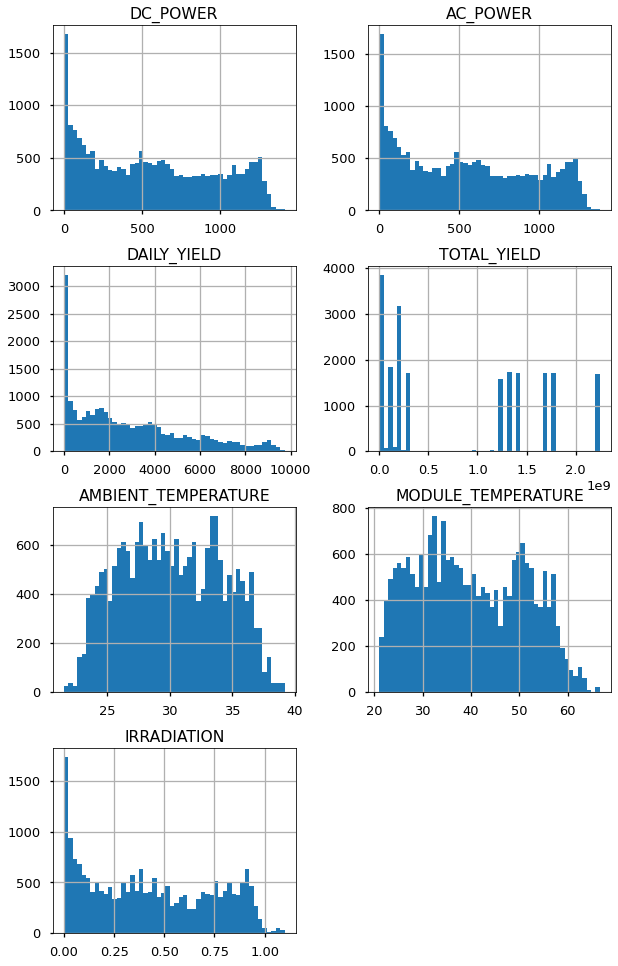

In [67]:
# Gerar um histograma para cada atributo numérico
dtSimetria = dtUnificadaTrativa4_3.drop(['DATE_TIME', 'DAY', 'HOUR'], axis = 1)
dtSimetria.hist(bins=50, figsize=(10,30), layout=(7,2))
plt.savefig(diretorioImagens + '/simetria_3.png', format='png', bbox_inches='tight')
plt.show()

Agora, é perceptível que a calda-longa que aparece no atributo de geração de energia, se assemelha com a calda-longa do atributo de irradiação, o que faz sentido, quando a irradiação for igual a zero, a geração de energia tende a ser igual a zero.

In [68]:
print(dtUnificadaTrativa4_3.skew(), '\nSoma:', sum(abs(dtUnificadaTrativa4_3.skew())))

DC_POWER               0.249611
AC_POWER               0.242521
DAILY_YIELD            0.804027
TOTAL_YIELD            0.317565
AMBIENT_TEMPERATURE    0.055203
MODULE_TEMPERATURE     0.156068
IRRADIATION            0.211024
DAY                    0.000662
HOUR                   0.003993
dtype: float64 
Soma: 2.040674634658309


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning:

Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.



### 3.5.3 Potência AC gerada para cada um dos 34 dias com tratamento para nulos

/usr/local/lib/python3.7/dist-packages/pandas/plotting/_matplotlib/tools.py:225: UserWarning:

When passing multiple axes, layout keyword is ignored

/usr/local/lib/python3.7/dist-packages/pandas/plotting/_matplotlib/__init__.py:71: UserWarning:

When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes

/usr/local/lib/python3.7/dist-packages/pandas/plotting/_matplotlib/tools.py:225: UserWarning:

When passing multiple axes, layout keyword is ignored

/usr/local/lib/python3.7/dist-packages/pandas/plotting/_matplotlib/__init__.py:71: UserWarning:

When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes

/usr/local/lib/python3.7/dist-packages/pandas/plotting/_matplotlib/tools.py:225: UserWarning:

When passing multiple axes, layout keyword is ignored

/usr/local/lib/python3.7/dist-packages/pandas/plotting/_matplotlib/__init__.py:71: UserWarning:

When passing multiple axes, sharex 

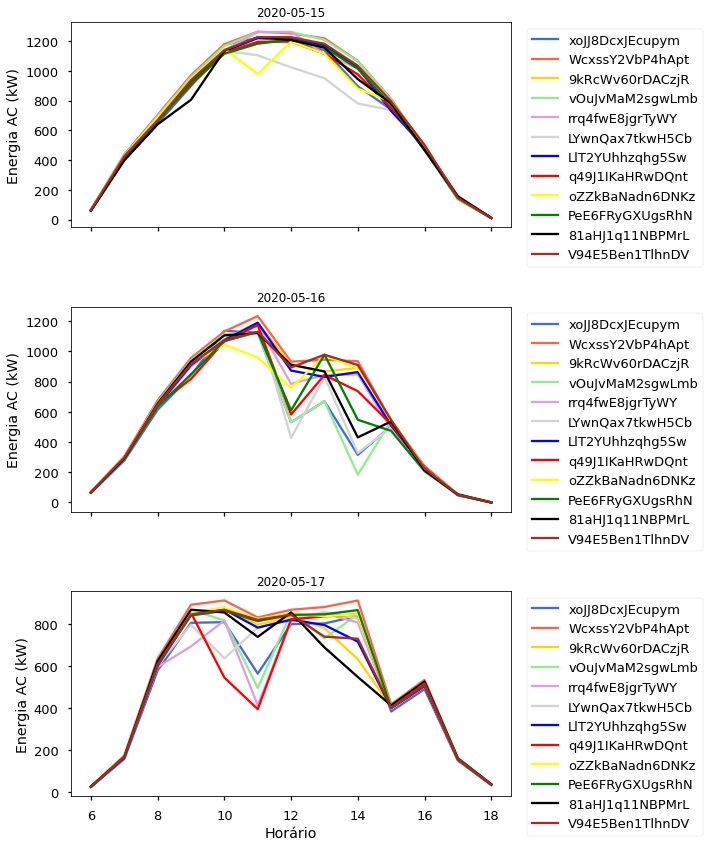

In [69]:
geracao=dtUnificadaTrativa4_3.copy()

geracao['Horário']=geracao['DATE_TIME'].dt.hour
geracao['Data']=geracao['DATE_TIME'].dt.date

# just for columns
cols=geracao.groupby(['Horário','Data'])['AC_POWER'].mean().unstack()

inversores = ['xoJJ8DcxJEcupym', 'WcxssY2VbP4hApt', '9kRcWv60rDACzjR', 'vOuJvMaM2sgwLmb', 'rrq4fwE8jgrTyWY', 'LYwnQax7tkwH5Cb', 'LlT2YUhhzqhg5Sw', 'q49J1IKaHRwDQnt', 'oZZkBaNadn6DNKz', 'PeE6FRyGXUgsRhN', '81aHJ1q11NBPMrL', 'V94E5Ben1TlhnDV']
cores = ['royalblue', 'tomato', 'gold', 'lightgreen', 'plum', 'lightgray', 'blue', 'red', 'yellow', 'green', 'black', 'brown']

inversores3259=dtUnificadaTrativa4_3.loc[dtUnificadaTrativa4_3['SOURCE_KEY']=='xoJJ8DcxJEcupym'].loc[dtUnificadaTrativa4_3['DATE_TIME'] < ('2020-05-18')]
inversores3259['Horário']=inversores3259['DATE_TIME'].dt.hour
inversores3259['Data']=inversores3259['DATE_TIME'].dt.date

ax=inversores3259.groupby(['Horário','Data'])['AC_POWER'].mean().unstack().plot(sharex=True,subplots=True,layout=(3,1),figsize=(10,12), color=cores[0])

j=1
for j in range(1,12):
    inversores3259_2=dtUnificadaTrativa4_3.loc[dtUnificadaTrativa4_3['SOURCE_KEY']==inversores[j]].loc[dtUnificadaTrativa4_3['DATE_TIME'] < ('2020-05-18')]
    inversores3259_2['Horário']=inversores3259_2['DATE_TIME'].dt.hour
    inversores3259_2['Data']=inversores3259_2['DATE_TIME'].dt.date
    inversores3259_2.groupby(['Horário','Data'])['AC_POWER'].mean().unstack().plot(sharex=True,subplots=True,layout=(3,1),figsize=(10,12), color=cores[j], ax=ax)
    j=j+1

i=0
for linha in range(len(ax)):
    for coluna in range(len(ax[linha])):
        ax[linha,coluna].set_title(cols.columns[i],size=12)
        ax[linha,coluna].set_ylabel('Energia AC (kW)')
        ax[linha,coluna].legend(inversores, bbox_to_anchor = (1.02, 1))
        i=i+1

plt.tight_layout()
plt.savefig(diretorioImagens + '/energia_AC_inversores_sem_nulos_1.png', format='png', bbox_inches='tight')
plt.show()

/usr/local/lib/python3.7/dist-packages/pandas/plotting/_matplotlib/tools.py:225: UserWarning:

When passing multiple axes, layout keyword is ignored

/usr/local/lib/python3.7/dist-packages/pandas/plotting/_matplotlib/__init__.py:71: UserWarning:

When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes

/usr/local/lib/python3.7/dist-packages/pandas/plotting/_matplotlib/tools.py:225: UserWarning:

When passing multiple axes, layout keyword is ignored

/usr/local/lib/python3.7/dist-packages/pandas/plotting/_matplotlib/__init__.py:71: UserWarning:

When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes

/usr/local/lib/python3.7/dist-packages/pandas/plotting/_matplotlib/tools.py:225: UserWarning:

When passing multiple axes, layout keyword is ignored

/usr/local/lib/python3.7/dist-packages/pandas/plotting/_matplotlib/__init__.py:71: UserWarning:

When passing multiple axes, sharex 

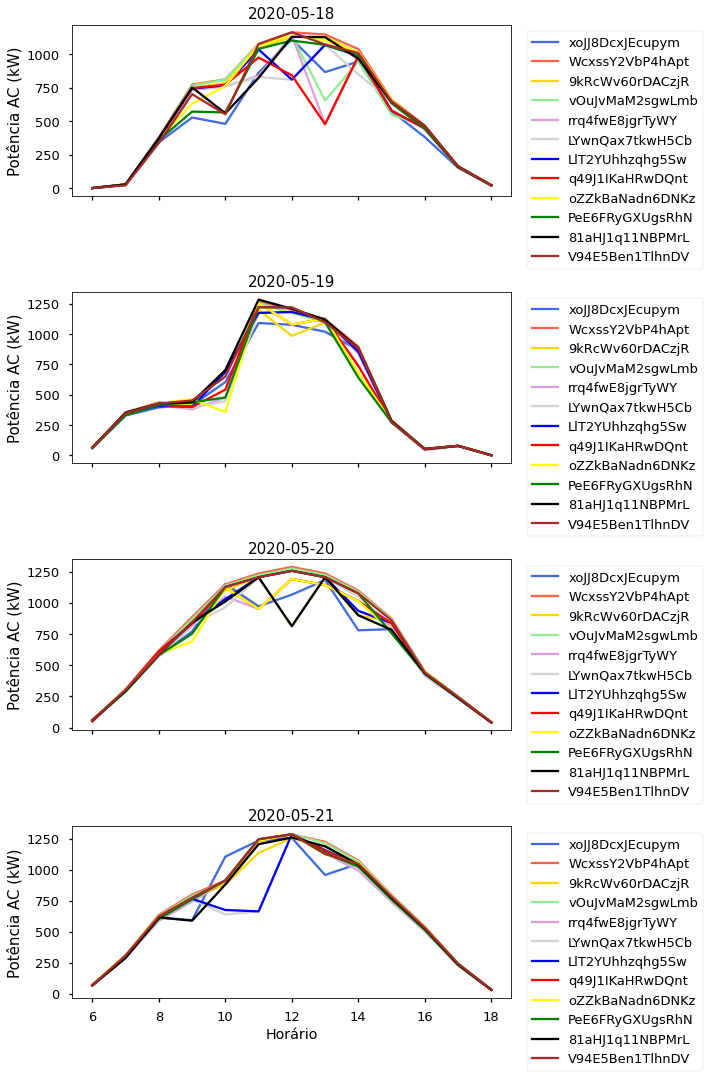

In [70]:
geracao=dtUnificadaTrativa4_3.loc[dtUnificadaTrativa4_3['DATE_TIME'] > ('2020-05-18')].copy()

geracao['Horário']=geracao['DATE_TIME'].dt.hour
geracao['Data']=geracao['DATE_TIME'].dt.date

# just for columns
cols=geracao.groupby(['Horário','Data'])['AC_POWER'].mean().unstack()

inversores = ['xoJJ8DcxJEcupym', 'WcxssY2VbP4hApt', '9kRcWv60rDACzjR', 'vOuJvMaM2sgwLmb', 'rrq4fwE8jgrTyWY', 'LYwnQax7tkwH5Cb', 'LlT2YUhhzqhg5Sw', 'q49J1IKaHRwDQnt', 'oZZkBaNadn6DNKz', 'PeE6FRyGXUgsRhN', '81aHJ1q11NBPMrL', 'V94E5Ben1TlhnDV']
cores = ['royalblue', 'tomato', 'gold', 'lightgreen', 'plum', 'lightgray', 'blue', 'red', 'yellow', 'green', 'black', 'brown']

inversores3259=dtUnificadaTrativa4_3.loc[dtUnificadaTrativa4_3['SOURCE_KEY']=='xoJJ8DcxJEcupym'].loc[(dtUnificadaTrativa4_3['DATE_TIME'] > ('2020-05-18')) & (dtUnificadaTrativa4_3['DATE_TIME'] < ('2020-05-22'))]
inversores3259['Horário']=inversores3259['DATE_TIME'].dt.hour
inversores3259['Data']=inversores3259['DATE_TIME'].dt.date

ax=inversores3259.groupby(['Horário','Data'])['AC_POWER'].mean().unstack().plot(sharex=True,subplots=True,layout=(4,1),figsize=(10,15), color=cores[0])

j=1
for j in range(1,12):
    inversores3259_2=dtUnificadaTrativa4_3.loc[dtUnificadaTrativa4_3['SOURCE_KEY']==inversores[j]].loc[(dtUnificadaTrativa4_3['DATE_TIME'] > ('2020-05-18')) & (dtUnificadaTrativa4_3['DATE_TIME'] < ('2020-05-22'))]
    inversores3259_2['Horário']=inversores3259_2['DATE_TIME'].dt.hour
    inversores3259_2['Data']=inversores3259_2['DATE_TIME'].dt.date
    inversores3259_2.groupby(['Horário','Data'])['AC_POWER'].mean().unstack().plot(sharex=True,subplots=True,layout=(4,1),figsize=(10,15), color=cores[j], ax=ax)
    j=j+1

i=0
for linha in range(len(ax)):
    for coluna in range(len(ax[linha])):
        ax[linha,coluna].set_title(cols.columns[i],size=15)
        ax[linha,coluna].set_ylabel('Potência AC (kW)', size=15)
        ax[linha,coluna].legend(inversores, bbox_to_anchor = (1.02, 1))
        i=i+1

plt.tight_layout()
plt.savefig(diretorioImagens + '/energia_AC_inversores_sem_nulos_2.png', format='png', bbox_inches='tight')
plt.show()

/usr/local/lib/python3.7/dist-packages/pandas/plotting/_matplotlib/tools.py:225: UserWarning:

When passing multiple axes, layout keyword is ignored

/usr/local/lib/python3.7/dist-packages/pandas/plotting/_matplotlib/__init__.py:71: UserWarning:

When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes

/usr/local/lib/python3.7/dist-packages/pandas/plotting/_matplotlib/tools.py:225: UserWarning:

When passing multiple axes, layout keyword is ignored

/usr/local/lib/python3.7/dist-packages/pandas/plotting/_matplotlib/__init__.py:71: UserWarning:

When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes

/usr/local/lib/python3.7/dist-packages/pandas/plotting/_matplotlib/tools.py:225: UserWarning:

When passing multiple axes, layout keyword is ignored

/usr/local/lib/python3.7/dist-packages/pandas/plotting/_matplotlib/__init__.py:71: UserWarning:

When passing multiple axes, sharex 

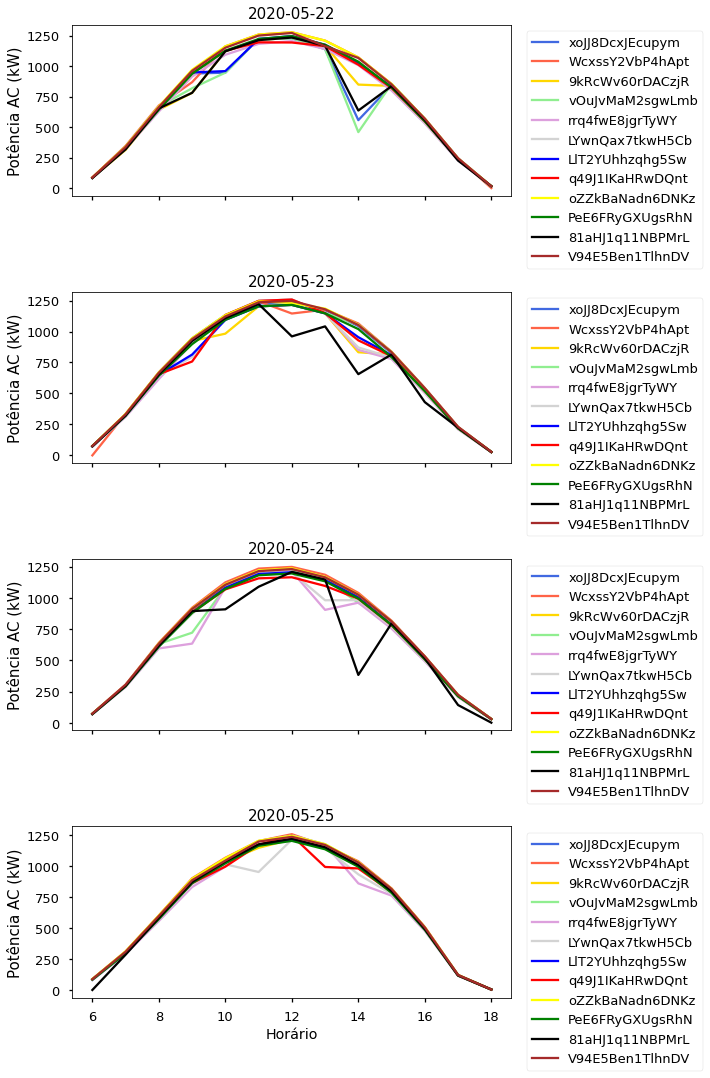

In [71]:
geracao=dtUnificadaTrativa4_3.loc[dtUnificadaTrativa4_3['DATE_TIME'] > ('2020-05-22')].copy()

geracao['Horário']=geracao['DATE_TIME'].dt.hour
geracao['Data']=geracao['DATE_TIME'].dt.date

# just for columns
cols=geracao.groupby(['Horário','Data'])['AC_POWER'].mean().unstack()

inversores = ['xoJJ8DcxJEcupym', 'WcxssY2VbP4hApt', '9kRcWv60rDACzjR', 'vOuJvMaM2sgwLmb', 'rrq4fwE8jgrTyWY', 'LYwnQax7tkwH5Cb', 'LlT2YUhhzqhg5Sw', 'q49J1IKaHRwDQnt', 'oZZkBaNadn6DNKz', 'PeE6FRyGXUgsRhN', '81aHJ1q11NBPMrL', 'V94E5Ben1TlhnDV']
cores = ['royalblue', 'tomato', 'gold', 'lightgreen', 'plum', 'lightgray', 'blue', 'red', 'yellow', 'green', 'black', 'brown']

inversores3259=dtUnificadaTrativa4_3.loc[dtUnificadaTrativa4_3['SOURCE_KEY']=='xoJJ8DcxJEcupym'].loc[(dtUnificadaTrativa4_3['DATE_TIME'] > ('2020-05-22')) & (dtUnificadaTrativa4_3['DATE_TIME'] < ('2020-05-26'))]
inversores3259['Horário']=inversores3259['DATE_TIME'].dt.hour
inversores3259['Data']=inversores3259['DATE_TIME'].dt.date

ax=inversores3259.groupby(['Horário','Data'])['AC_POWER'].mean().unstack().plot(sharex=True,subplots=True,layout=(4,1),figsize=(10,15), color=cores[0])

j=1
for j in range(1,12):
    inversores3259_2=dtUnificadaTrativa4_3.loc[dtUnificadaTrativa4_3['SOURCE_KEY']==inversores[j]].loc[(dtUnificadaTrativa4_3['DATE_TIME'] > ('2020-05-22')) & (dtUnificadaTrativa4_3['DATE_TIME'] < ('2020-05-26'))]
    inversores3259_2['Horário']=inversores3259_2['DATE_TIME'].dt.hour
    inversores3259_2['Data']=inversores3259_2['DATE_TIME'].dt.date
    inversores3259_2.groupby(['Horário','Data'])['AC_POWER'].mean().unstack().plot(sharex=True,subplots=True,layout=(4,1),figsize=(10,15), color=cores[j], ax=ax)
    j=j+1

i=0
for linha in range(len(ax)):
    for coluna in range(len(ax[linha])):
        ax[linha,coluna].set_title(cols.columns[i],size=15)
        ax[linha,coluna].set_ylabel('Potência AC (kW)', size=15)
        ax[linha,coluna].legend(inversores, bbox_to_anchor = (1.02, 1))
        i=i+1

plt.tight_layout()
plt.savefig(diretorioImagens + '/energia_AC_inversores_sem_nulos_3.png', format='png', bbox_inches='tight')
plt.show()

/usr/local/lib/python3.7/dist-packages/pandas/plotting/_matplotlib/tools.py:225: UserWarning:

When passing multiple axes, layout keyword is ignored

/usr/local/lib/python3.7/dist-packages/pandas/plotting/_matplotlib/__init__.py:71: UserWarning:

When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes

/usr/local/lib/python3.7/dist-packages/pandas/plotting/_matplotlib/tools.py:225: UserWarning:

When passing multiple axes, layout keyword is ignored

/usr/local/lib/python3.7/dist-packages/pandas/plotting/_matplotlib/__init__.py:71: UserWarning:

When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes

/usr/local/lib/python3.7/dist-packages/pandas/plotting/_matplotlib/tools.py:225: UserWarning:

When passing multiple axes, layout keyword is ignored

/usr/local/lib/python3.7/dist-packages/pandas/plotting/_matplotlib/__init__.py:71: UserWarning:

When passing multiple axes, sharex 

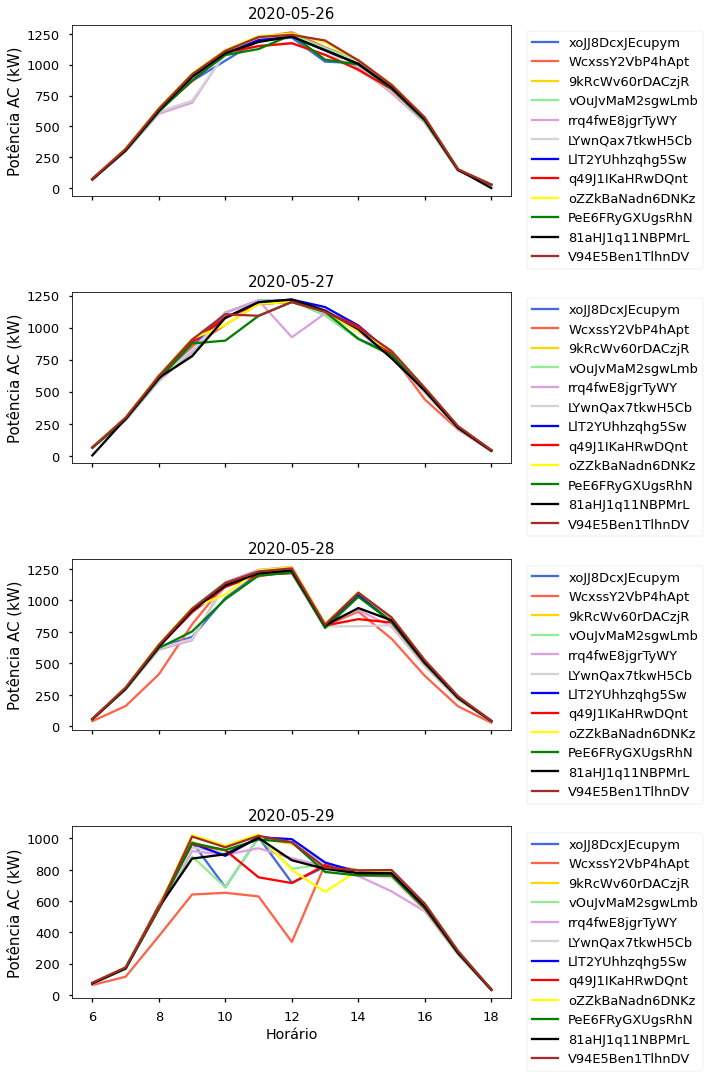

In [72]:
geracao=dtUnificadaTrativa4_3.loc[dtUnificadaTrativa4_3['DATE_TIME'] > ('2020-05-26')].copy()

geracao['Horário']=geracao['DATE_TIME'].dt.hour
geracao['Data']=geracao['DATE_TIME'].dt.date

# just for columns
cols=geracao.groupby(['Horário','Data'])['AC_POWER'].mean().unstack()

inversores = ['xoJJ8DcxJEcupym', 'WcxssY2VbP4hApt', '9kRcWv60rDACzjR', 'vOuJvMaM2sgwLmb', 'rrq4fwE8jgrTyWY', 'LYwnQax7tkwH5Cb', 'LlT2YUhhzqhg5Sw', 'q49J1IKaHRwDQnt', 'oZZkBaNadn6DNKz', 'PeE6FRyGXUgsRhN', '81aHJ1q11NBPMrL', 'V94E5Ben1TlhnDV']
cores = ['royalblue', 'tomato', 'gold', 'lightgreen', 'plum', 'lightgray', 'blue', 'red', 'yellow', 'green', 'black', 'brown']

inversores3259=dtUnificadaTrativa4_3.loc[dtUnificadaTrativa4_3['SOURCE_KEY']=='xoJJ8DcxJEcupym'].loc[(dtUnificadaTrativa4_3['DATE_TIME'] > ('2020-05-26')) & (dtUnificadaTrativa4_3['DATE_TIME'] < ('2020-05-30'))]
inversores3259['Horário']=inversores3259['DATE_TIME'].dt.hour
inversores3259['Data']=inversores3259['DATE_TIME'].dt.date

ax=inversores3259.groupby(['Horário','Data'])['AC_POWER'].mean().unstack().plot(sharex=True,subplots=True,layout=(4,1),figsize=(10,15), color=cores[0])

j=1
for j in range(1,12):
    inversores3259_2=dtUnificadaTrativa4_3.loc[dtUnificadaTrativa4_3['SOURCE_KEY']==inversores[j]].loc[(dtUnificadaTrativa4_3['DATE_TIME'] > ('2020-05-26')) & (dtUnificadaTrativa4_3['DATE_TIME'] < ('2020-05-30'))]
    inversores3259_2['Horário']=inversores3259_2['DATE_TIME'].dt.hour
    inversores3259_2['Data']=inversores3259_2['DATE_TIME'].dt.date
    inversores3259_2.groupby(['Horário','Data'])['AC_POWER'].mean().unstack().plot(sharex=True,subplots=True,layout=(4,1),figsize=(10,15), color=cores[j], ax=ax)
    j=j+1

i=0
for linha in range(len(ax)):
    for coluna in range(len(ax[linha])):
        ax[linha,coluna].set_title(cols.columns[i],size=15)
        ax[linha,coluna].set_ylabel('Potência AC (kW)', size=15)
        ax[linha,coluna].legend(inversores, bbox_to_anchor = (1.02, 1))
        i=i+1

plt.tight_layout()
plt.savefig(diretorioImagens + '/energia_AC_inversores_sem_nulos_4.png', format='png', bbox_inches='tight')
plt.show()

In [73]:
geracao=dtUnificadaTrativa4_3.loc[dtUnificadaTrativa4_3['DATE_TIME'] > ('2020-05-30')].copy()

geracao['Horário']=geracao['DATE_TIME'].dt.hour
geracao['Data']=geracao['DATE_TIME'].dt.date

# just for columns
cols=geracao.groupby(['Horário','Data'])['AC_POWER'].mean().unstack()

inversores = ['xoJJ8DcxJEcupym', 'WcxssY2VbP4hApt', '9kRcWv60rDACzjR', 'vOuJvMaM2sgwLmb', 'rrq4fwE8jgrTyWY', 'LYwnQax7tkwH5Cb', 'LlT2YUhhzqhg5Sw', 'q49J1IKaHRwDQnt', 'oZZkBaNadn6DNKz', 'PeE6FRyGXUgsRhN', '81aHJ1q11NBPMrL', 'V94E5Ben1TlhnDV']
cores = ['royalblue', 'tomato', 'gold', 'lightgreen', 'plum', 'lightgray', 'blue', 'red', 'yellow', 'green', 'black', 'brown']

inversores3259=dtUnificadaTrativa4_3.loc[dtUnificadaTrativa4_3['SOURCE_KEY']=='xoJJ8DcxJEcupym'].loc[(dtUnificadaTrativa4_3['DATE_TIME'] > ('2020-05-30')) & (dtUnificadaTrativa4_3['DATE_TIME'] < ('2020-06-03'))]
inversores3259['Horário']=inversores3259['DATE_TIME'].dt.hour
inversores3259['Data']=inversores3259['DATE_TIME'].dt.date

ax=inversores3259.groupby(['Horário','Data'])['AC_POWER'].mean().unstack().plot(sharex=True,subplots=True,layout=(4,1),figsize=(10,15), color=cores[0])

j=1
for j in range(1,12):
    inversores3259_2=dtUnificadaTrativa4_3.loc[dtUnificadaTrativa4_3['SOURCE_KEY']==inversores[j]].loc[(dtUnificadaTrativa4_3['DATE_TIME'] > ('2020-05-30')) & (dtUnificadaTrativa4_3['DATE_TIME'] < ('2020-06-03'))]
    inversores3259_2['Horário']=inversores3259_2['DATE_TIME'].dt.hour
    inversores3259_2['Data']=inversores3259_2['DATE_TIME'].dt.date
    inversores3259_2.groupby(['Horário','Data'])['AC_POWER'].mean().unstack().plot(sharex=True,subplots=True,layout=(4,1),figsize=(10,15), color=cores[j], ax=ax)
    j=j+1

i=0
for linha in range(len(ax)):
    for coluna in range(len(ax[linha])):
        ax[linha,coluna].set_title(cols.columns[i],size=15)
        ax[linha,coluna].set_ylabel('Potência AC (kW)', size=15)
        ax[linha,coluna].legend(inversores, bbox_to_anchor = (1.02, 1))
        i=i+1

plt.tight_layout()
plt.savefig(diretorioImagens + '/energia_AC_inversores_sem_nulos_5.png', format='png', bbox_inches='tight')
plt.show()

/usr/local/lib/python3.7/dist-packages/pandas/plotting/_matplotlib/tools.py:225: UserWarning:

When passing multiple axes, layout keyword is ignored

/usr/local/lib/python3.7/dist-packages/pandas/plotting/_matplotlib/__init__.py:71: UserWarning:

When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes

/usr/local/lib/python3.7/dist-packages/pandas/plotting/_matplotlib/tools.py:225: UserWarning:

When passing multiple axes, layout keyword is ignored

/usr/local/lib/python3.7/dist-packages/pandas/plotting/_matplotlib/__init__.py:71: UserWarning:

When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes

/usr/local/lib/python3.7/dist-packages/pandas/plotting/_matplotlib/tools.py:225: UserWarning:

When passing multiple axes, layout keyword is ignored

/usr/local/lib/python3.7/dist-packages/pandas/plotting/_matplotlib/__init__.py:71: UserWarning:

When passing multiple axes, sharex 

In [74]:
geracao=dtUnificadaTrativa4_3.loc[dtUnificadaTrativa4_3['DATE_TIME'] > ('2020-06-03')].copy()

geracao['Horário']=geracao['DATE_TIME'].dt.hour
geracao['Data']=geracao['DATE_TIME'].dt.date

# just for columns
cols=geracao.groupby(['Horário','Data'])['AC_POWER'].mean().unstack()

inversores = ['xoJJ8DcxJEcupym', 'WcxssY2VbP4hApt', '9kRcWv60rDACzjR', 'vOuJvMaM2sgwLmb', 'rrq4fwE8jgrTyWY', 'LYwnQax7tkwH5Cb', 'LlT2YUhhzqhg5Sw', 'q49J1IKaHRwDQnt', 'oZZkBaNadn6DNKz', 'PeE6FRyGXUgsRhN', '81aHJ1q11NBPMrL', 'V94E5Ben1TlhnDV']
cores = ['royalblue', 'tomato', 'gold', 'lightgreen', 'plum', 'lightgray', 'blue', 'red', 'yellow', 'green', 'black', 'brown']

inversores3259=dtUnificadaTrativa4_3.loc[dtUnificadaTrativa4_3['SOURCE_KEY']=='xoJJ8DcxJEcupym'].loc[(dtUnificadaTrativa4_3['DATE_TIME'] > ('2020-06-03')) & (dtUnificadaTrativa4_3['DATE_TIME'] < ('2020-06-07'))]
inversores3259['Horário']=inversores3259['DATE_TIME'].dt.hour
inversores3259['Data']=inversores3259['DATE_TIME'].dt.date

ax=inversores3259.groupby(['Horário','Data'])['AC_POWER'].mean().unstack().plot(sharex=True,subplots=True,layout=(4,1),figsize=(10,15), color=cores[0])

j=1
for j in range(1,12):
    inversores3259_2=dtUnificadaTrativa4_3.loc[dtUnificadaTrativa4_3['SOURCE_KEY']==inversores[j]].loc[(dtUnificadaTrativa4_3['DATE_TIME'] > ('2020-06-03')) & (dtUnificadaTrativa4_3['DATE_TIME'] < ('2020-06-07'))]
    inversores3259_2['Horário']=inversores3259_2['DATE_TIME'].dt.hour
    inversores3259_2['Data']=inversores3259_2['DATE_TIME'].dt.date
    inversores3259_2.groupby(['Horário','Data'])['AC_POWER'].mean().unstack().plot(sharex=True,subplots=True,layout=(4,1),figsize=(10,15), color=cores[j], ax=ax)
    j=j+1

i=0
for linha in range(len(ax)):
    for coluna in range(len(ax[linha])):
        ax[linha,coluna].set_title(cols.columns[i],size=15)
        ax[linha,coluna].set_ylabel('Potência AC (kW)', size=15)
        ax[linha,coluna].legend(inversores, bbox_to_anchor = (1.02, 1))
        i=i+1

plt.tight_layout()
plt.savefig(diretorioImagens + '/energia_AC_inversores_sem_nulos_6.png', format='png', bbox_inches='tight')
plt.show()

/usr/local/lib/python3.7/dist-packages/pandas/plotting/_matplotlib/tools.py:225: UserWarning:

When passing multiple axes, layout keyword is ignored

/usr/local/lib/python3.7/dist-packages/pandas/plotting/_matplotlib/__init__.py:71: UserWarning:

When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes

/usr/local/lib/python3.7/dist-packages/pandas/plotting/_matplotlib/tools.py:225: UserWarning:

When passing multiple axes, layout keyword is ignored

/usr/local/lib/python3.7/dist-packages/pandas/plotting/_matplotlib/__init__.py:71: UserWarning:

When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes

/usr/local/lib/python3.7/dist-packages/pandas/plotting/_matplotlib/tools.py:225: UserWarning:

When passing multiple axes, layout keyword is ignored

/usr/local/lib/python3.7/dist-packages/pandas/plotting/_matplotlib/__init__.py:71: UserWarning:

When passing multiple axes, sharex 

In [75]:
geracao=dtUnificadaTrativa4_3.loc[dtUnificadaTrativa4_3['DATE_TIME'] > ('2020-06-07')].copy()

geracao['Horário']=geracao['DATE_TIME'].dt.hour
geracao['Data']=geracao['DATE_TIME'].dt.date

# just for columns
cols=geracao.groupby(['Horário','Data'])['AC_POWER'].mean().unstack()

inversores = ['xoJJ8DcxJEcupym', 'WcxssY2VbP4hApt', '9kRcWv60rDACzjR', 'vOuJvMaM2sgwLmb', 'rrq4fwE8jgrTyWY', 'LYwnQax7tkwH5Cb', 'LlT2YUhhzqhg5Sw', 'q49J1IKaHRwDQnt', 'oZZkBaNadn6DNKz', 'PeE6FRyGXUgsRhN', '81aHJ1q11NBPMrL', 'V94E5Ben1TlhnDV']
cores = ['royalblue', 'tomato', 'gold', 'lightgreen', 'plum', 'lightgray', 'blue', 'red', 'yellow', 'green', 'black', 'brown']

inversores3259=dtUnificadaTrativa4_3.loc[dtUnificadaTrativa4_3['SOURCE_KEY']=='xoJJ8DcxJEcupym'].loc[(dtUnificadaTrativa4_3['DATE_TIME'] > ('2020-06-07')) & (dtUnificadaTrativa4_3['DATE_TIME'] < ('2020-06-11'))]
inversores3259['Horário']=inversores3259['DATE_TIME'].dt.hour
inversores3259['Data']=inversores3259['DATE_TIME'].dt.date

ax=inversores3259.groupby(['Horário','Data'])['AC_POWER'].mean().unstack().plot(sharex=True,subplots=True,layout=(4,1),figsize=(10,15), color=cores[0])

j=1
for j in range(1,12):
    inversores3259_2=dtUnificadaTrativa4_3.loc[dtUnificadaTrativa4_3['SOURCE_KEY']==inversores[j]].loc[(dtUnificadaTrativa4_3['DATE_TIME'] > ('2020-06-07')) & (dtUnificadaTrativa4_3['DATE_TIME'] < ('2020-06-11'))]
    inversores3259_2['Horário']=inversores3259_2['DATE_TIME'].dt.hour
    inversores3259_2['Data']=inversores3259_2['DATE_TIME'].dt.date
    inversores3259_2.groupby(['Horário','Data'])['AC_POWER'].mean().unstack().plot(sharex=True,subplots=True,layout=(4,1),figsize=(10,15), color=cores[j], ax=ax)
    j=j+1

i=0
for linha in range(len(ax)):
    for coluna in range(len(ax[linha])):
        ax[linha,coluna].set_title(cols.columns[i],size=15)
        ax[linha,coluna].set_ylabel('Potência AC (kW)', size=15)
        ax[linha,coluna].legend(inversores, bbox_to_anchor = (1.02, 1))
        i=i+1

plt.tight_layout()
plt.savefig(diretorioImagens + '/energia_AC_inversores_sem_nulos_7.png', format='png', bbox_inches='tight')
plt.show()

/usr/local/lib/python3.7/dist-packages/pandas/plotting/_matplotlib/tools.py:225: UserWarning:

When passing multiple axes, layout keyword is ignored

/usr/local/lib/python3.7/dist-packages/pandas/plotting/_matplotlib/__init__.py:71: UserWarning:

When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes

/usr/local/lib/python3.7/dist-packages/pandas/plotting/_matplotlib/tools.py:225: UserWarning:

When passing multiple axes, layout keyword is ignored

/usr/local/lib/python3.7/dist-packages/pandas/plotting/_matplotlib/__init__.py:71: UserWarning:

When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes

/usr/local/lib/python3.7/dist-packages/pandas/plotting/_matplotlib/tools.py:225: UserWarning:

When passing multiple axes, layout keyword is ignored

/usr/local/lib/python3.7/dist-packages/pandas/plotting/_matplotlib/__init__.py:71: UserWarning:

When passing multiple axes, sharex 

/usr/local/lib/python3.7/dist-packages/pandas/plotting/_matplotlib/tools.py:225: UserWarning:

When passing multiple axes, layout keyword is ignored

/usr/local/lib/python3.7/dist-packages/pandas/plotting/_matplotlib/__init__.py:71: UserWarning:

When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes

/usr/local/lib/python3.7/dist-packages/pandas/plotting/_matplotlib/tools.py:225: UserWarning:

When passing multiple axes, layout keyword is ignored

/usr/local/lib/python3.7/dist-packages/pandas/plotting/_matplotlib/__init__.py:71: UserWarning:

When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes

/usr/local/lib/python3.7/dist-packages/pandas/plotting/_matplotlib/tools.py:225: UserWarning:

When passing multiple axes, layout keyword is ignored

/usr/local/lib/python3.7/dist-packages/pandas/plotting/_matplotlib/__init__.py:71: UserWarning:

When passing multiple axes, sharex 

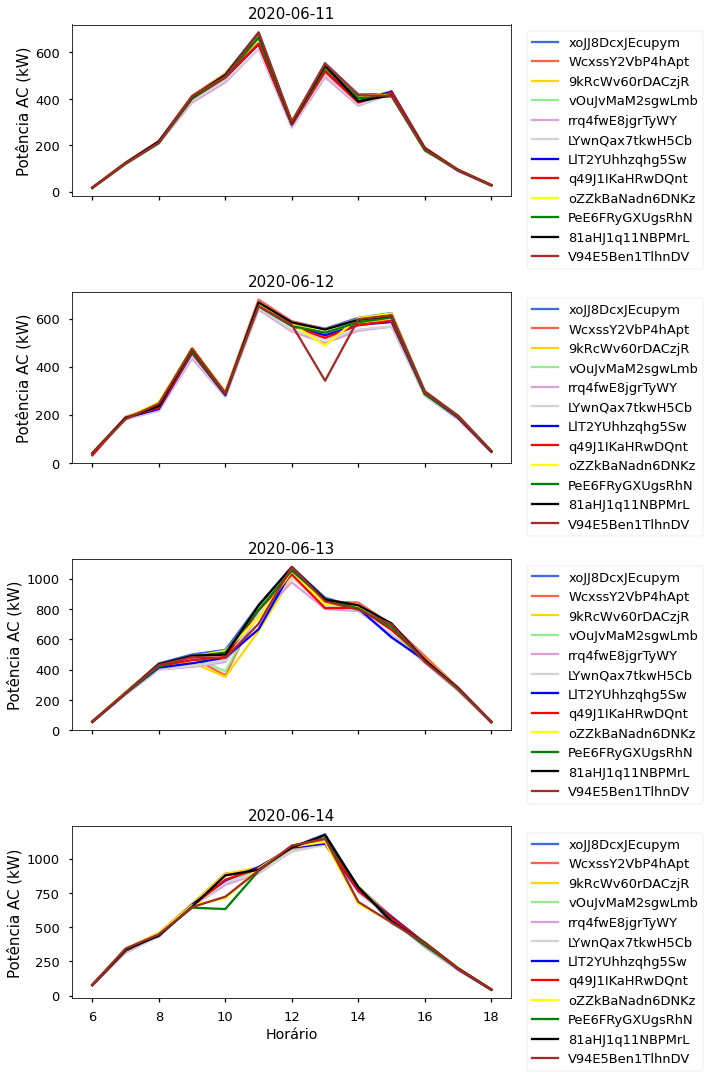

In [76]:
geracao=dtUnificadaTrativa4_3.loc[dtUnificadaTrativa4_3['DATE_TIME'] > ('2020-06-11')].copy()

geracao['Horário']=geracao['DATE_TIME'].dt.hour
geracao['Data']=geracao['DATE_TIME'].dt.date

# just for columns
cols=geracao.groupby(['Horário','Data'])['AC_POWER'].mean().unstack()

inversores = ['xoJJ8DcxJEcupym', 'WcxssY2VbP4hApt', '9kRcWv60rDACzjR', 'vOuJvMaM2sgwLmb', 'rrq4fwE8jgrTyWY', 'LYwnQax7tkwH5Cb', 'LlT2YUhhzqhg5Sw', 'q49J1IKaHRwDQnt', 'oZZkBaNadn6DNKz', 'PeE6FRyGXUgsRhN', '81aHJ1q11NBPMrL', 'V94E5Ben1TlhnDV']
cores = ['royalblue', 'tomato', 'gold', 'lightgreen', 'plum', 'lightgray', 'blue', 'red', 'yellow', 'green', 'black', 'brown']

inversores3259=dtUnificadaTrativa4_3.loc[dtUnificadaTrativa4_3['SOURCE_KEY']=='xoJJ8DcxJEcupym'].loc[(dtUnificadaTrativa4_3['DATE_TIME'] > ('2020-06-11')) & (dtUnificadaTrativa4_3['DATE_TIME'] < ('2020-06-15'))]
inversores3259['Horário']=inversores3259['DATE_TIME'].dt.hour
inversores3259['Data']=inversores3259['DATE_TIME'].dt.date

ax=inversores3259.groupby(['Horário','Data'])['AC_POWER'].mean().unstack().plot(sharex=True,subplots=True,layout=(4,1),figsize=(10,15), color=cores[0])

j=1
for j in range(1,12):
    inversores3259_2=dtUnificadaTrativa4_3.loc[dtUnificadaTrativa4_3['SOURCE_KEY']==inversores[j]].loc[(dtUnificadaTrativa4_3['DATE_TIME'] > ('2020-06-11')) & (dtUnificadaTrativa4_3['DATE_TIME'] < ('2020-06-15'))]
    inversores3259_2['Horário']=inversores3259_2['DATE_TIME'].dt.hour
    inversores3259_2['Data']=inversores3259_2['DATE_TIME'].dt.date
    inversores3259_2.groupby(['Horário','Data'])['AC_POWER'].mean().unstack().plot(sharex=True,subplots=True,layout=(4,1),figsize=(10,15), color=cores[j], ax=ax)
    j=j+1

i=0
for linha in range(len(ax)):
    for coluna in range(len(ax[linha])):
        ax[linha,coluna].set_title(cols.columns[i],size=15)
        ax[linha,coluna].set_ylabel('Potência AC (kW)', size=15)
        ax[linha,coluna].legend(inversores, bbox_to_anchor = (1.02, 1))
        i=i+1

plt.tight_layout()
plt.savefig(diretorioImagens + '/energia_AC_inversores_sem_nulos_8.png', format='png', bbox_inches='tight')
plt.show()

/usr/local/lib/python3.7/dist-packages/pandas/plotting/_matplotlib/tools.py:225: UserWarning:

When passing multiple axes, layout keyword is ignored

/usr/local/lib/python3.7/dist-packages/pandas/plotting/_matplotlib/__init__.py:71: UserWarning:

When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes

/usr/local/lib/python3.7/dist-packages/pandas/plotting/_matplotlib/tools.py:225: UserWarning:

When passing multiple axes, layout keyword is ignored

/usr/local/lib/python3.7/dist-packages/pandas/plotting/_matplotlib/__init__.py:71: UserWarning:

When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes

/usr/local/lib/python3.7/dist-packages/pandas/plotting/_matplotlib/tools.py:225: UserWarning:

When passing multiple axes, layout keyword is ignored

/usr/local/lib/python3.7/dist-packages/pandas/plotting/_matplotlib/__init__.py:71: UserWarning:

When passing multiple axes, sharex 

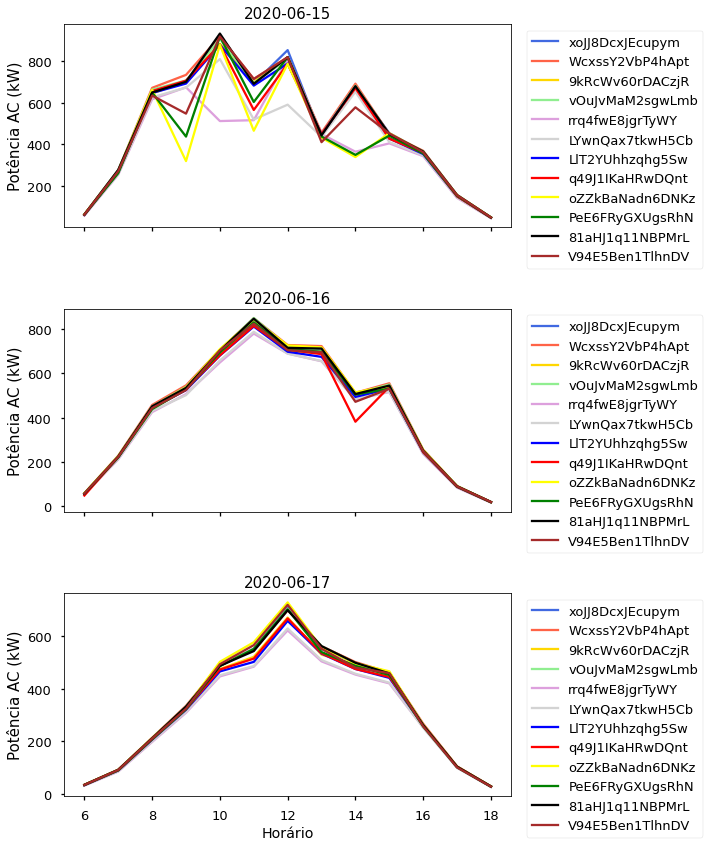

In [77]:
geracao=dtUnificadaTrativa4_3.loc[dtUnificadaTrativa4_3['DATE_TIME'] > ('2020-06-15')].copy()

geracao['Horário']=geracao['DATE_TIME'].dt.hour
geracao['Data']=geracao['DATE_TIME'].dt.date

# just for columns
cols=geracao.groupby(['Horário','Data'])['AC_POWER'].mean().unstack()

inversores = ['xoJJ8DcxJEcupym', 'WcxssY2VbP4hApt', '9kRcWv60rDACzjR', 'vOuJvMaM2sgwLmb', 'rrq4fwE8jgrTyWY', 'LYwnQax7tkwH5Cb', 'LlT2YUhhzqhg5Sw', 'q49J1IKaHRwDQnt', 'oZZkBaNadn6DNKz', 'PeE6FRyGXUgsRhN', '81aHJ1q11NBPMrL', 'V94E5Ben1TlhnDV']
cores = ['royalblue', 'tomato', 'gold', 'lightgreen', 'plum', 'lightgray', 'blue', 'red', 'yellow', 'green', 'black', 'brown']

inversores3259=dtUnificadaTrativa4_3.loc[dtUnificadaTrativa4_3['SOURCE_KEY']=='xoJJ8DcxJEcupym'].loc[(dtUnificadaTrativa4_3['DATE_TIME'] > ('2020-06-15')) & (dtUnificadaTrativa4_3['DATE_TIME'] < ('2020-06-18'))]
inversores3259['Horário']=inversores3259['DATE_TIME'].dt.hour
inversores3259['Data']=inversores3259['DATE_TIME'].dt.date

ax=inversores3259.groupby(['Horário','Data'])['AC_POWER'].mean().unstack().plot(sharex=True,subplots=True,layout=(3,1),figsize=(10,12), color=cores[0])

j=1
for j in range(1,12):
    inversores3259_2=dtUnificadaTrativa4_3.loc[dtUnificadaTrativa4_3['SOURCE_KEY']==inversores[j]].loc[(dtUnificadaTrativa4_3['DATE_TIME'] > ('2020-06-15')) & (dtUnificadaTrativa4_3['DATE_TIME'] < ('2020-06-18'))]
    inversores3259_2['Horário']=inversores3259_2['DATE_TIME'].dt.hour
    inversores3259_2['Data']=inversores3259_2['DATE_TIME'].dt.date
    inversores3259_2.groupby(['Horário','Data'])['AC_POWER'].mean().unstack().plot(sharex=True,subplots=True,layout=(3,1),figsize=(10,12), color=cores[j], ax=ax)
    j=j+1

i=0
for linha in range(len(ax)):
    for coluna in range(len(ax[linha])):
        ax[linha,coluna].set_title(cols.columns[i],size=15)
        ax[linha,coluna].set_ylabel('Potência AC (kW)', size=15)
        ax[linha,coluna].legend(inversores, bbox_to_anchor = (1.02, 1))
        i=i+1

plt.tight_layout()
plt.savefig(diretorioImagens + '/energia_AC_inversores_sem_nulos_9.png', format='png', bbox_inches='tight')
plt.show()

Com as trativas realizadas, obtivemos uma simetria muito melhor para todos os atributos, agora todos estão próximos de zero, quanto mais próximo de zero, mais simétrica é a distribuição dos dados.

## 3.6 Correlação

In [78]:
# Posiciona o atributo a ser previsto na última coluna do dataset
colunaACPower = dtUnificadaTrativa4_3['AC_POWER']
dtUnificadaTratativa4_4 = dtUnificadaTrativa4_3.copy()
dtUnificadaTratativa4_4 = dtUnificadaTratativa4_4.drop(['AC_POWER'], axis=1)
dtUnificadaTratativa4_4["AC_POWER"] = colunaACPower

dtUnificadaTratativa4_4

DATE_TIME       SOURCE_KEY   DC_POWER  DAILY_YIELD  \
0     2020-05-15 06:00:00  81aHJ1q11NBPMrL  14.773333     0.733333   
1     2020-05-15 06:00:00  9kRcWv60rDACzjR  15.380000     1.866667   
2     2020-05-15 06:00:00  LYwnQax7tkwH5Cb  15.566667     1.266667   
3     2020-05-15 06:00:00  LlT2YUhhzqhg5Sw  15.180000     1.066667   
4     2020-05-15 06:00:00  PeE6FRyGXUgsRhN  14.506667     0.666667   
...                   ...              ...        ...          ...   
21163 2020-06-17 17:45:00  oZZkBaNadn6DNKz  99.440000  4348.466667   
21164 2020-06-17 17:45:00  q49J1IKaHRwDQnt  97.480000  4116.400000   
21165 2020-06-17 17:45:00  rrq4fwE8jgrTyWY  92.320000  3892.466667   
21166 2020-06-17 17:45:00  vOuJvMaM2sgwLmb  99.493333  4280.466667   
21167 2020-06-17 17:45:00  xoJJ8DcxJEcupym  99.233333  4274.533333   

        TOTAL_YIELD  AMBIENT_TEMPERATURE  MODULE_TEMPERATURE  IRRADIATION  \
0      1.215279e+09            24.742787           24.077230     0.012962   
1      2.247720e+09            24.742787           24.077230     0.012962   
2      1.794959e+09            24.742787           24.077230     0.012962   
3      2.825928e+08            24.742787           24.077230     0.012962   
4      1.348351e+09            24.742787           24.077230     0.012962   
...             ...                  ...                 ...          ...   
21163  1.708288e+09            26.091664           27.235657     0.065480   
21164  5.207174e+05            26.091664           27.235657     0.065480   
21165  1.211313e+08            26.091664           27.235657     0.065480   
21166  2.427649e+06            26.091664           27.235657     0.065480   
21167  2.093357e+08            26.091664           27.235657     0.065480   

       DAY  HOUR   AC_POWER  
0       15     6  14.246667  
1       15     6  14.840000  
2       15     6  15.020000  
3       15     6  14.673333  
4       15     6  13.993333  
...    ...   ...        ...  
21163   17    17  96.620000  
21164   17    17  94.700000  
21165   17    17  89.680000  
21166   17    17  96.693333  
21167   17    17  96.413333  

[21168 rows x 11 columns]

In [79]:
# Cria coluna "AC_POWER_FUTURO"
dtUnificadaTratativa4_4["AC_POWER_FUTURO"] = colunaACPower.shift(-1)
dtUnificadaTratativa4_4 = dtUnificadaTratativa4_4.dropna()

dtUnificadaTratativa4_4

DATE_TIME       SOURCE_KEY   DC_POWER  DAILY_YIELD  \
0     2020-05-15 06:00:00  81aHJ1q11NBPMrL  14.773333     0.733333   
1     2020-05-15 06:00:00  9kRcWv60rDACzjR  15.380000     1.866667   
2     2020-05-15 06:00:00  LYwnQax7tkwH5Cb  15.566667     1.266667   
3     2020-05-15 06:00:00  LlT2YUhhzqhg5Sw  15.180000     1.066667   
4     2020-05-15 06:00:00  PeE6FRyGXUgsRhN  14.506667     0.666667   
...                   ...              ...        ...          ...   
21162 2020-06-17 17:45:00  WcxssY2VbP4hApt  99.873333  4288.933333   
21163 2020-06-17 17:45:00  oZZkBaNadn6DNKz  99.440000  4348.466667   
21164 2020-06-17 17:45:00  q49J1IKaHRwDQnt  97.480000  4116.400000   
21165 2020-06-17 17:45:00  rrq4fwE8jgrTyWY  92.320000  3892.466667   
21166 2020-06-17 17:45:00  vOuJvMaM2sgwLmb  99.493333  4280.466667   

        TOTAL_YIELD  AMBIENT_TEMPERATURE  MODULE_TEMPERATURE  IRRADIATION  \
0      1.215279e+09            24.742787           24.077230     0.012962   
1      2.247720e+09            24.742787           24.077230     0.012962   
2      1.794959e+09            24.742787           24.077230     0.012962   
3      2.825928e+08            24.742787           24.077230     0.012962   
4      1.348351e+09            24.742787           24.077230     0.012962   
...             ...                  ...                 ...          ...   
21162  1.819119e+08            26.091664           27.235657     0.065480   
21163  1.708288e+09            26.091664           27.235657     0.065480   
21164  5.207174e+05            26.091664           27.235657     0.065480   
21165  1.211313e+08            26.091664           27.235657     0.065480   
21166  2.427649e+06            26.091664           27.235657     0.065480   

       DAY  HOUR   AC_POWER  AC_POWER_FUTURO  
0       15     6  14.246667        14.840000  
1       15     6  14.840000        15.020000  
2       15     6  15.020000        14.673333  
3       15     6  14.673333        13.993333  
4       15     6  13.993333        14.680000  
...    ...   ...        ...              ...  
21162   17    17  97.046667        96.620000  
21163   17    17  96.620000        94.700000  
21164   17    17  94.700000        89.680000  
21165   17    17  89.680000        96.693333  
21166   17    17  96.693333        96.413333  

[21167 rows x 12 columns]

In [80]:
# Remover atributos DAILY_YIELD e TOTAL_YIELD

dtUnificadaTratativa4_5 = dtUnificadaTratativa4_4.copy()
dtUnificadaTratativa4_5 = dtUnificadaTratativa4_5.drop(['DAILY_YIELD', 'TOTAL_YIELD'], axis=1)

dtUnificadaTratativa4_5

DATE_TIME       SOURCE_KEY   DC_POWER  AMBIENT_TEMPERATURE  \
0     2020-05-15 06:00:00  81aHJ1q11NBPMrL  14.773333            24.742787   
1     2020-05-15 06:00:00  9kRcWv60rDACzjR  15.380000            24.742787   
2     2020-05-15 06:00:00  LYwnQax7tkwH5Cb  15.566667            24.742787   
3     2020-05-15 06:00:00  LlT2YUhhzqhg5Sw  15.180000            24.742787   
4     2020-05-15 06:00:00  PeE6FRyGXUgsRhN  14.506667            24.742787   
...                   ...              ...        ...                  ...   
21162 2020-06-17 17:45:00  WcxssY2VbP4hApt  99.873333            26.091664   
21163 2020-06-17 17:45:00  oZZkBaNadn6DNKz  99.440000            26.091664   
21164 2020-06-17 17:45:00  q49J1IKaHRwDQnt  97.480000            26.091664   
21165 2020-06-17 17:45:00  rrq4fwE8jgrTyWY  92.320000            26.091664   
21166 2020-06-17 17:45:00  vOuJvMaM2sgwLmb  99.493333            26.091664   

       MODULE_TEMPERATURE  IRRADIATION  DAY  HOUR   AC_POWER  AC_POWER_FUTURO  
0               24.077230     0.012962   15     6  14.246667        14.840000  
1               24.077230     0.012962   15     6  14.840000        15.020000  
2               24.077230     0.012962   15     6  15.020000        14.673333  
3               24.077230     0.012962   15     6  14.673333        13.993333  
4               24.077230     0.012962   15     6  13.993333        14.680000  
...                   ...          ...  ...   ...        ...              ...  
21162           27.235657     0.065480   17    17  97.046667        96.620000  
21163           27.235657     0.065480   17    17  96.620000        94.700000  
21164           27.235657     0.065480   17    17  94.700000        89.680000  
21165           27.235657     0.065480   17    17  89.680000        96.693333  
21166           27.235657     0.065480   17    17  96.693333        96.413333  

[21167 rows x 10 columns]

A seguir será visto o quanto cada atributo se correlaciona com a energia gerada (AC_POWER). Percebe-se uma forte correlação positiva, tirando a DC_POWER, na irradiação e na temperatura do módulo, o que faz sentido, visto que quanto maior a irradiação solar, maior deve ser a energia gerada, e quanto maior a irradiação sobre os módulos, maior será sua temperatura. Os atributos de rendimento e tempo por sua vez, mostram que não existe uma correlação linear com a geração de energia, visto que os coeficientes são muito próximos de zero.

A baixa correlação para as variáveis de tempo, pode se dar pela baixa quantidade de dados da amostra.

In [81]:
corr_matrix = dtUnificadaTratativa4_5.corr()

corr_matrix["AC_POWER_FUTURO"].sort_values(ascending=False)

AC_POWER_FUTURO        1.000000
DC_POWER               0.952057
AC_POWER               0.952038
IRRADIATION            0.932355
MODULE_TEMPERATURE     0.859518
AMBIENT_TEMPERATURE    0.516717
DAY                    0.134700
HOUR                  -0.080288
Name: AC_POWER_FUTURO, dtype: float64

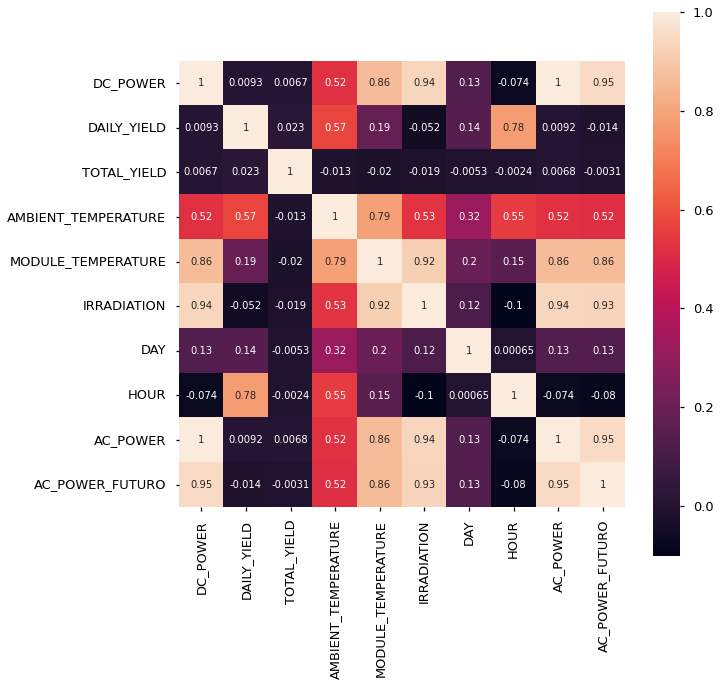

In [82]:
fig = plt.figure(figsize = (10, 10))

sns.heatmap(dtUnificadaTratativa4_4.corr(method = 'pearson'), annot = True, square = True)
plt.show()
fig.savefig(diretorioImagens + '/corr_all.png', format='png', bbox_inches='tight')

No gráfico acima, percebe-se que a colinearidade entre os atributos de temperatura são muito próximas de 1, o que pode ser um forte indício de multicolinearidade, ou seja, dois atributos que representam a mesma coisa. Fica evidente que o atributo de potência DC é multicolinear com o atributo de potência AC, mas isto já era perceptível com a análise gráfica de geração de energia.

Visto que os atributos de rendimento não apresentam influência no atributo de geração de energia, supõe-se que estes serão excluídos da amostra de dados, mas antes, será realizada uma análise de multicolinearidade entre as variáveis independentes.

### 3.7.1 Multicolinearidade

Na multicolinearidade se tem atributos preditores que se correlacionam com outros preditores, são atributos redundantes na amostra de dados.

In [83]:
dtX = dtUnificadaTratativa4_5.copy()
dtX = dtX.drop(['DATE_TIME', 'SOURCE_KEY', 'DC_POWER', 'AC_POWER_FUTURO'], axis = 1)

# Gerando matriz de correlação e recombinando
corr = np.corrcoef(dtX, rowvar = 0)
autovalor, autovetor = np.linalg.eig(corr)

menor = 999
index = 0
for i, val in enumerate(autovalor):
    if val < menor:
        menor = val
        index = i

print('Menor autovalor:', menor, 'Index:', index)

Menor autovalor: 0.018823712490992083 Index: 4


In [84]:
menorAutovetor = abs(autovetor[:, 5])

for i, val in enumerate(autovetor[:, 5]):
    print('Variável', i,':', abs(val))

Variável 0 : 0.34830819747335606
Variável 1 : 0.3773150369480042
Variável 2 : 0.5103156430693909
Variável 3 : 0.07230915683339958
Variável 4 : 0.14851102110168218
Variável 5 : 0.6697824791332186


In [85]:
# Exibir atributos com o maior valor absoluto para o autovetor
colunas = dtX.columns

colunas[[5, 2, 0, 1]]

Index(['AC_POWER', 'IRRADIATION', 'AMBIENT_TEMPERATURE', 'MODULE_TEMPERATURE'], dtype='object')

Atributos com valores VIF próximos de 1, indicam que não existe correlação entre eles, a seguir é calculado o valor VIF para todos os atributos independentes da amostra.

In [86]:
def calcular_VIF(X):
    vif = pd.DataFrame()
    vif['Atributos'] = X.columns
    vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    
    return vif

calcular_VIF(dtX)

Atributos         VIF
0  AMBIENT_TEMPERATURE  226.559285
1   MODULE_TEMPERATURE  368.071720
2          IRRADIATION   66.457431
3                  DAY    5.396682
4                 HOUR   21.334049
5             AC_POWER   23.743236

Percebe-se um alto valor para os atributos de temperatura e irradiação. Primeiramente será removido o atributo 'AMBIENT_TEMPERATURE' e em seguida o VIF será novamente calculado.

In [87]:
dtX = dtUnificadaTratativa4_5.copy()
dtX = dtX.drop(['DATE_TIME', 'SOURCE_KEY', 'DC_POWER', 'AMBIENT_TEMPERATURE', 'AC_POWER_FUTURO'], axis = 1)

calcular_VIF(dtX)

Atributos        VIF
0  MODULE_TEMPERATURE  67.788354
1         IRRADIATION  39.165955
2                 DAY   4.930535
3                HOUR  18.520168
4            AC_POWER  23.720416

In [88]:
dtX = dtUnificadaTratativa4_5.copy()
dtX = dtX.drop(['DATE_TIME', 'SOURCE_KEY', 'DC_POWER', 'AMBIENT_TEMPERATURE', 'AC_POWER_FUTURO', 'MODULE_TEMPERATURE'], axis = 1)

calcular_VIF(dtX)

Atributos        VIF
0  IRRADIATION  23.329870
1          DAY   3.842360
2         HOUR   3.960310
3     AC_POWER  23.718767

In [89]:
dtX = dtUnificadaTratativa4_5.copy()
dtX = dtX.drop(['DATE_TIME', 'SOURCE_KEY', 'DC_POWER', 'AMBIENT_TEMPERATURE', 'AC_POWER_FUTURO', 'MODULE_TEMPERATURE', 'AC_POWER'], axis = 1)

calcular_VIF(dtX)

Atributos       VIF
0  IRRADIATION  2.603135
1          DAY  3.827207
2         HOUR  3.935756

## 3.7 Relatório OLS

In [90]:
# Carregando atributos com exceção do atributo alvo
X = dtUnificadaTratativa4_5.drop(['DATE_TIME', 'SOURCE_KEY', 'AC_POWER_FUTURO', 'DC_POWER'], axis = 1)
Xc = sm.add_constant(X)

y = dtUnificadaTratativa4_5['AC_POWER_FUTURO'].values

# Criando e treinando modelo
modelo = sm.OLS(y, Xc)
modelo1 = modelo.fit()

# Visualizando resumo do modelo
modelo1.summary()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning:

In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only



<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.920
Model:                            OLS   Adj. R-squared:                  0.920
Method:                 Least Squares   F-statistic:                 4.070e+04
Date:                Fri, 15 Apr 2022   Prob (F-statistic):               0.00
Time:                        12:20:28   Log-Likelihood:            -1.2999e+05
No. Observations:               21167   AIC:                         2.600e+05
Df Residuals:                   21160   BIC:                         2.601e+05
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                 -13.6795      7.530     -1.817      0.069     -28.439       1.080
AMBIENT_TEMPERATURE     1.9886      0.607      3.279      0.001       0.800       3.177
MODULE_TEMPERATURE     -0.8710      0.381     -2.287      0.022      -1.618      -0.125
IRRADIATION           445.0229     12.013     37.044      0.000     421.476     468.570
DAY                     0.2653      0.102      2.594      0.010       0.065       0.466
HOUR                   -0.5907      0.317     -1.864      0.062      -1.212       0.030
AC_POWER                0.6374      0.006    114.915      0.000       0.626       0.648
==============================================================================
Omnibus:                    12784.912   Durbin-Watson:                   2.295
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           519961.055
Skew:                          -2.293   Prob(JB):                         0.00
Kurtosis:                      26.844   Cond. No.                     1.07e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.07e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

O modelo explica 92% da variância dos dados.

Percebe-se que os atributos HOUR e MODULE_TEMPERATURE apresentaram um valor muito baixo para t, o que indica uma baixa relevância para o modelo preditivo.

In [91]:
# Carregando atributos com exceção do atributo alvo
X = dtUnificadaTratativa4_5.drop(['DATE_TIME', 'SOURCE_KEY', 'DC_POWER', 'AMBIENT_TEMPERATURE', 'AC_POWER_FUTURO', 'MODULE_TEMPERATURE', 'AC_POWER'], axis = 1)
Xc = sm.add_constant(X)

y = dtUnificadaTratativa4_5['AC_POWER_FUTURO'].values

# Criando e treinando modelo
modelo = sm.OLS(y, Xc)
modelo2 = modelo.fit()

# Visualizando resumo do modelo
modelo2.summary()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning:

In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only



<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.870
Model:                            OLS   Adj. R-squared:                  0.870
Method:                 Least Squares   F-statistic:                 4.722e+04
Date:                Fri, 15 Apr 2022   Prob (F-statistic):               0.00
Time:                        12:20:28   Log-Likelihood:            -1.3516e+05
No. Observations:               21167   AIC:                         2.703e+05
Df Residuals:                   21163   BIC:                         2.704e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           1.5337      4.075      0.376      0.707      -6.453       9.521
IRRADIATION  1197.4516      3.228    371.007      0.000    1191.125    1203.778
DAY             1.0796      0.116      9.271      0.000       0.851       1.308
HOUR            1.4977      0.265      5.649      0.000       0.978       2.017
==============================================================================
Omnibus:                    16785.299   Durbin-Watson:                   0.809
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           390706.698
Skew:                          -3.737   Prob(JB):                         0.00
Kurtosis:                      22.676   Cond. No.                         94.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [92]:
# Carregando atributos com exceção do atributo alvo
X = dtUnificadaTratativa4_5.drop(['DATE_TIME', 'SOURCE_KEY', 'DC_POWER', 'AMBIENT_TEMPERATURE', 'AC_POWER_FUTURO', 'MODULE_TEMPERATURE', 'AC_POWER', 'DAY', 'HOUR'], axis = 1)
Xc = sm.add_constant(X)

y = dtUnificadaTratativa4_5['AC_POWER_FUTURO'].values

# Criando e treinando modelo
modelo = sm.OLS(y, Xc)
modelo2 = modelo.fit()

# Visualizando resumo do modelo
modelo2.summary()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning:

In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only



<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.869
Model:                            OLS   Adj. R-squared:                  0.869
Method:                 Least Squares   F-statistic:                 1.408e+05
Date:                Fri, 15 Apr 2022   Prob (F-statistic):               0.00
Time:                        12:20:28   Log-Likelihood:            -1.3522e+05
No. Observations:               21167   AIC:                         2.704e+05
Df Residuals:                   21165   BIC:                         2.705e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          36.0291      1.693     21.276      0.000      32.710      39.348
IRRADIATION  1199.1831      3.196    375.171      0.000    1192.918    1205.448
==============================================================================
Omnibus:                    16906.776   Durbin-Watson:                   0.805
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           399867.985
Skew:                          -3.772   Prob(JB):                         0.00
Kurtosis:                      22.911   Cond. No.                         3.88
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [93]:
# Excluir atributos independentes descartados com a análise de correlação e multicolinearidade

dtUnificadaTratativa5 = dtUnificadaTratativa4_5.drop(['DC_POWER'], axis = 1)
dtTratadaCompleta = dtUnificadaTratativa5.copy()

dtUnificadaTratativa5.describe()

AMBIENT_TEMPERATURE  MODULE_TEMPERATURE   IRRADIATION           DAY  \
count         21167.000000        21167.000000  21167.000000  21167.000000   
mean             30.187409           39.962949      0.429964     16.006756   
std               3.994710           10.986917      0.309532      8.535107   
min              21.567336           21.031937      0.000000      1.000000   
25%              26.876638           30.890153      0.135998      9.000000   
50%              30.041596           38.873928      0.395320     16.000000   
75%              33.495552           49.584121      0.713452     23.000000   
max              39.181638           66.635953      1.098766     31.000000   

               HOUR      AC_POWER  AC_POWER_FUTURO  
count  21167.000000  21167.000000     21167.000000  
mean      11.991260    551.630915       551.634797  
std        3.741287    398.120459       398.115620  
min        6.000000      0.000000         0.000000  
25%        9.000000    176.106667       176.106667  
50%       12.000000    515.264286       515.264286  
75%       15.000000    896.291667       896.291667  
max       18.000000   1378.766667      1378.766667

In [94]:
dtTratadaCompleta.describe()

AMBIENT_TEMPERATURE  MODULE_TEMPERATURE   IRRADIATION           DAY  \
count         21167.000000        21167.000000  21167.000000  21167.000000   
mean             30.187409           39.962949      0.429964     16.006756   
std               3.994710           10.986917      0.309532      8.535107   
min              21.567336           21.031937      0.000000      1.000000   
25%              26.876638           30.890153      0.135998      9.000000   
50%              30.041596           38.873928      0.395320     16.000000   
75%              33.495552           49.584121      0.713452     23.000000   
max              39.181638           66.635953      1.098766     31.000000   

               HOUR      AC_POWER  AC_POWER_FUTURO  
count  21167.000000  21167.000000     21167.000000  
mean      11.991260    551.630915       551.634797  
std        3.741287    398.120459       398.115620  
min        6.000000      0.000000         0.000000  
25%        9.000000    176.106667       176.106667  
50%       12.000000    515.264286       515.264286  
75%       15.000000    896.291667       896.291667  
max       18.000000   1378.766667      1378.766667

In [95]:
dtUnificadaTratativa5["SOURCE_KEY"].value_counts()

81aHJ1q11NBPMrL    1764
9kRcWv60rDACzjR    1764
LYwnQax7tkwH5Cb    1764
LlT2YUhhzqhg5Sw    1764
PeE6FRyGXUgsRhN    1764
V94E5Ben1TlhnDV    1764
WcxssY2VbP4hApt    1764
oZZkBaNadn6DNKz    1764
q49J1IKaHRwDQnt    1764
rrq4fwE8jgrTyWY    1764
vOuJvMaM2sgwLmb    1764
xoJJ8DcxJEcupym    1763
Name: SOURCE_KEY, dtype: int64

## 3.8 Outliers

In [96]:
def boxplot_individuais(data, colunas, largura = 10, altura = 8):
    fig = plt.figure()
    fig.subplots_adjust(hspace = 0.4, wspace = 0.4)
    fig.set_figheight(altura)
    fig.set_figwidth(largura)
    
    ajusteColunas = math.ceil(len(colunas) / 2)
    
    for i, coluna in enumerate(colunas):
        ax = fig.add_subplot(ajusteColunas, 2, i + 1)
        sns.boxplot(x = data[coluna])
        
    plt.tight_layout()
    plt.savefig(diretorioImagens + '/outliers.png')  
    plt.show()

Pode-se ver que nenhum atributo apresenta valores extremos, que fujam muito do padrão.

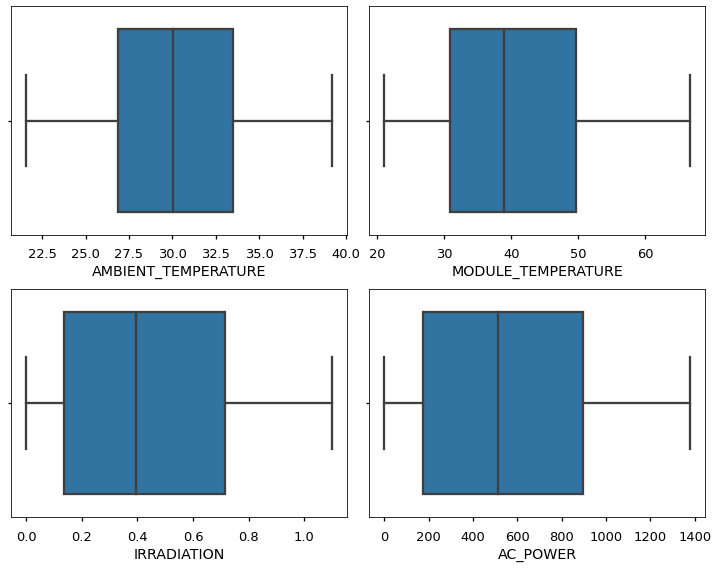

In [97]:
# Separa os valores qualitativos da amostra
qualitativos = dtUnificadaTratativa5.drop(["AC_POWER", "IRRADIATION"], axis = 1).columns

# Retira valores qualitativos da amostra (Data e número de identificação dos inversores)
quantitativos = dtUnificadaTratativa5.drop(['DATE_TIME', 'SOURCE_KEY', 'AC_POWER_FUTURO', "HOUR", "DAY"], axis = 1).columns

boxplot_individuais(dtUnificadaTratativa5, quantitativos[0:5])

## 3.9 Normalização

In [98]:
dtUnificadaTratativa5[quantitativos]

AMBIENT_TEMPERATURE  MODULE_TEMPERATURE  IRRADIATION   AC_POWER
0                24.742787           24.077230     0.012962  14.246667
1                24.742787           24.077230     0.012962  14.840000
2                24.742787           24.077230     0.012962  15.020000
3                24.742787           24.077230     0.012962  14.673333
4                24.742787           24.077230     0.012962  13.993333
...                    ...                 ...          ...        ...
21162            26.091664           27.235657     0.065480  97.046667
21163            26.091664           27.235657     0.065480  96.620000
21164            26.091664           27.235657     0.065480  94.700000
21165            26.091664           27.235657     0.065480  89.680000
21166            26.091664           27.235657     0.065480  96.693333

[21167 rows x 4 columns]

In [99]:
dtTratadaCompleta

DATE_TIME       SOURCE_KEY  AMBIENT_TEMPERATURE  \
0     2020-05-15 06:00:00  81aHJ1q11NBPMrL            24.742787   
1     2020-05-15 06:00:00  9kRcWv60rDACzjR            24.742787   
2     2020-05-15 06:00:00  LYwnQax7tkwH5Cb            24.742787   
3     2020-05-15 06:00:00  LlT2YUhhzqhg5Sw            24.742787   
4     2020-05-15 06:00:00  PeE6FRyGXUgsRhN            24.742787   
...                   ...              ...                  ...   
21162 2020-06-17 17:45:00  WcxssY2VbP4hApt            26.091664   
21163 2020-06-17 17:45:00  oZZkBaNadn6DNKz            26.091664   
21164 2020-06-17 17:45:00  q49J1IKaHRwDQnt            26.091664   
21165 2020-06-17 17:45:00  rrq4fwE8jgrTyWY            26.091664   
21166 2020-06-17 17:45:00  vOuJvMaM2sgwLmb            26.091664   

       MODULE_TEMPERATURE  IRRADIATION  DAY  HOUR   AC_POWER  AC_POWER_FUTURO  
0               24.077230     0.012962   15     6  14.246667        14.840000  
1               24.077230     0.012962   15     6  14.840000        15.020000  
2               24.077230     0.012962   15     6  15.020000        14.673333  
3               24.077230     0.012962   15     6  14.673333        13.993333  
4               24.077230     0.012962   15     6  13.993333        14.680000  
...                   ...          ...  ...   ...        ...              ...  
21162           27.235657     0.065480   17    17  97.046667        96.620000  
21163           27.235657     0.065480   17    17  96.620000        94.700000  
21164           27.235657     0.065480   17    17  94.700000        89.680000  
21165           27.235657     0.065480   17    17  89.680000        96.693333  
21166           27.235657     0.065480   17    17  96.693333        96.413333  

[21167 rows x 9 columns]

In [100]:
#dtNormalizada.to_csv(diretorioDados + '/planilha_tratada_normalizada_completa.csv')
dtTratadaCompleta.to_csv(diretorioDados + '/planilha_tratada_completa_2.csv')

In [101]:
#dtUnificadaTrativaNormalizadaCompleta.to_csv(diretorioDados + '/planilha_tratada_normalizada.csv')
#dtUnificadaTratativa5.to_csv(diretorioDados + '/planilha_tratada.csv')